# 0.0 Imports

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import inflection
from scipy.stats.contingency import association
from sklearn.preprocessing import MinMaxScaler, RobustScaler, LabelEncoder, OrdinalEncoder, TargetEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import neighbors as nh
from boruta import BorutaPy
import numpy as np
import scikitplot as skplt
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from sklearn.metrics import make_scorer
import pickle

In [3]:
# ajuste de layout de gráficos
plt.style.use('bmh')
plt.rcParams.update({
    'figure.figsize': (9,6),
    'figure.autolayout': True,
    'axes.titlepad': 10,
    'axes.labelpad': 8
})
sns.set()

## 0.1 Helper functions

In [4]:
def f1_rank(ytrue, ypred):
    k2=k
    if k2 == 0:
        print('K deve ser diferente de 0!')
        return 0
    else:
        y_true = ytrue.values
        y_pred = ypred#[:,1]
        yzip = list(zip(y_true, y_pred))
        ysorted = sorted(yzip, key=lambda x: x[1], reverse=True)
        pos_sum=0
        for i in ysorted[0:k2]:
            pos_sum += i[0]
        p = round(pos_sum/k2, 3)
        r = pos_sum/sum(y_true)
        f1 = round(2*(p*r)/(p+r),3)
        return f1

In [5]:
def metrics_k(ytrue, ypred):
    k2=k
    if k2 == 0:
        print('K deve ser diferente de 0!')
        return 0
    else:
        y_true = ytrue.values
        y_pred = ypred[:,1]
        yzip = list(zip(y_true, y_pred))
        ysorted = sorted(yzip, key=lambda x: x[1], reverse=True)
        pos_sum=0
        for i in ysorted[0:k2]:
            pos_sum += i[0]
        p = round(pos_sum/k2, 3)
        r = round(pos_sum/sum(y_true),3)
        f1 = round(2*(p*r)/(p+r),3)
        print(f'Precision@k: {p}. Recall@k: {r}. F1Score@k: {f1}')
        return p, r, f1

In [6]:
def precision_k(y_true, y_pred, k):
    y_true = y_true.values
    y_pred = y_pred[:,1]
    yzip = list(zip(y_true, y_pred))
    ysorted = sorted(yzip, key=lambda x: x[1], reverse=True)
    pos_sum=0
    for i in ysorted[0:k]:
        pos_sum += i[0]
    p = round(pos_sum/k, 3)
    return p

In [7]:
def recall_k(y_true, y_pred, k):
    y_true = y_true.values
    y_pred = y_pred[:,1]
    yzip = list(zip(y_true, y_pred))
    ysorted = sorted(yzip, key=lambda x: x[1], reverse=True)
    pos_sum=0
    for i in ysorted[0:k]:
        pos_sum += i[0]    
    r = round(pos_sum/sum(y_true), 3)    
    return r

In [8]:
def f1_k(precision_k, recall_k):
    f1 = round(2*(precision_k*recall_k)/(precision_k+recall_k), 3)
    return f1

# 1.0 Descrição dos dados

In [9]:
# leitura dos dados
df_raw = pd.read_csv('data/train.csv')
df1 = df_raw.copy()
df1.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [10]:
# renomear colunas
cols_old = list(df1.columns)
cols_new =  list(map(lambda x: inflection.underscore(x), cols_old))
df1.columns = cols_new
df1.columns

Index(['id', 'gender', 'age', 'driving_license', 'region_code',
       'previously_insured', 'vehicle_age', 'vehicle_damage', 'annual_premium',
       'policy_sales_channel', 'vintage', 'response'],
      dtype='object')

In [11]:
# Dimensões
df1.shape

(381109, 12)

In [12]:
# dados faltantes
df1.isna().sum()

id                      0
gender                  0
age                     0
driving_license         0
region_code             0
previously_insured      0
vehicle_age             0
vehicle_damage          0
annual_premium          0
policy_sales_channel    0
vintage                 0
response                0
dtype: int64

In [13]:
# tipos
df1.dtypes

id                        int64
gender                   object
age                       int64
driving_license           int64
region_code             float64
previously_insured        int64
vehicle_age              object
vehicle_damage           object
annual_premium          float64
policy_sales_channel    float64
vintage                   int64
response                  int64
dtype: object

## 1.1 Separação de numéricos e categóricos

In [14]:
#dados numéricos
df_num = df1.select_dtypes(exclude='object')
df_num.head(1)

,id,age,driving_license,region_code,previously_insured,annual_premium,policy_sales_channel,vintage,response
0,1,44,1,28.0,0,40454.0,26.0,217,1


In [15]:
# dados categóricos
df_cat = df1.select_dtypes(include='object')
df_cat.head(1)

,gender,vehicle_age,vehicle_damage
0,Male,> 2 Years,Yes


## 1.2 Estatística descritiva

### 1.2.1 Dados numéricos

In [16]:
stats = df_num.describe().T
stats

,count,mean,std,min,25%,50%,75%,max
id,381109.0,190555.000000,110016.836208,1.0,95278.0,190555.0,285832.0,381109.0
age,381109.0,38.822584,15.511611,20.0,25.0,36.0,49.0,85.0
driving_license,381109.0,0.997869,0.046110,0.0,1.0,1.0,1.0,1.0
region_code,381109.0,26.388807,13.229888,0.0,15.0,28.0,35.0,52.0
previously_insured,381109.0,0.458210,0.498251,0.0,0.0,0.0,1.0,1.0
annual_premium,381109.0,30564.389581,17213.155057,2630.0,24405.0,31669.0,39400.0,540165.0
policy_sales_channel,381109.0,112.034295,54.203995,1.0,29.0,133.0,152.0,163.0
vintage,381109.0,154.347397,83.671304,10.0,82.0,154.0,227.0,299.0
response,381109.0,0.122563,0.327936,0.0,0.0,0.0,0.0,1.0


In [17]:
stats['skew'] = df_num.apply(lambda x: x.skew())
stats['kurtosis'] = df_num.apply(lambda x: x.kurtosis())

stats

,count,mean,std,min,25%,50%,75%,max,skew,kurtosis
id,381109.0,190555.000000,110016.836208,1.0,95278.0,190555.0,285832.0,381109.0,9.443274e-16,-1.200000
age,381109.0,38.822584,15.511611,20.0,25.0,36.0,49.0,85.0,6.725390e-01,-0.565655
driving_license,381109.0,0.997869,0.046110,0.0,1.0,1.0,1.0,1.0,-2.159518e+01,464.354302
region_code,381109.0,26.388807,13.229888,0.0,15.0,28.0,35.0,52.0,-1.152664e-01,-0.867857
previously_insured,381109.0,0.458210,0.498251,0.0,0.0,0.0,1.0,1.0,1.677471e-01,-1.971871
annual_premium,381109.0,30564.389581,17213.155057,2630.0,24405.0,31669.0,39400.0,540165.0,1.766087e+00,34.004569
policy_sales_channel,381109.0,112.034295,54.203995,1.0,29.0,133.0,152.0,163.0,-9.000081e-01,-0.970810
vintage,381109.0,154.347397,83.671304,10.0,82.0,154.0,227.0,299.0,3.029517e-03,-1.200688
response,381109.0,0.122563,0.327936,0.0,0.0,0.0,0.0,1.0,2.301906e+00,3.298788


### 1.2.2 Dados categóricos

In [18]:
df_cat.apply(lambda x: x.unique())

gender                             [Male, Female]
vehicle_age       [> 2 Years, 1-2 Year, < 1 Year]
vehicle_damage                          [Yes, No]
dtype: object

# 2.0 Feature Engineering

Não foi necessário criar novas features

# 3.0 Filtragem de variáveis

Não foi necessário limpar os dados

# 4.0 Análise Exploratória de Dados(EDA)

### 4.0.1 Levantamento de Hipóteses

Entidades e atributos
* Clientes
    - gênero
    - idade
    - salário
    - estado civil
    - filhos
    - profissão
    - tempo segurado
    - valor do seguro
    - estilo de condução
* Vendedores
    - tempo de experiência
    - qtd vendas
* Veículos
    - valor
    - idade
    - modelo
    - tipo
    - dano
* Local
    - IDH
    - índice de violência
    - valor m2
* Tempo
    - estação do ano

### Hipóteses

* H1 - Pessoas mais velhas são mais propensas a comprar
* H2 - Pessoas do gênero feminino são mais propensas
* H3 - Pessoas há mais tempo seguradas são mais propensas
* H4 - Pessoas com maior valor de seguro são mais propensas
* H5 - Clientes com veículos mais novos vão ter maior propensão
* H6 - Clientes que tiveram dano no veículo têm maior propensão
* H7 - Clientes que já possuem seguro têm menos propensão de adquirir outro

## 4.1 Análise univariada

In [22]:
df4 = df1.copy()

### 4.1.1 Variável Resposta

In [19]:
df_aux = df4[['id', 'response']].groupby('response').count().reset_index()
df_aux

,response,id
0,0,334399
1,1,46710


In [20]:
# proporção compradores/total

ratio = round(int(df_aux['id'][df_aux['response'] == 1].iloc[0]) / int(df_aux['id'].sum()), 2)
ratio

0.12

<Axes: xlabel='response', ylabel='id'>

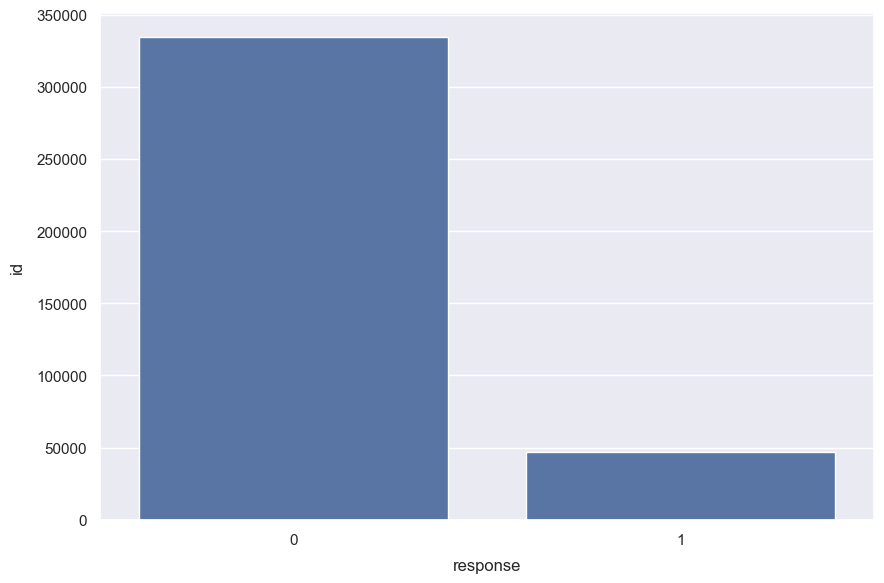

In [21]:
sns.barplot(df_aux, x = 'response', y= 'id')

### 4.1.2 Variáveis Numéricas

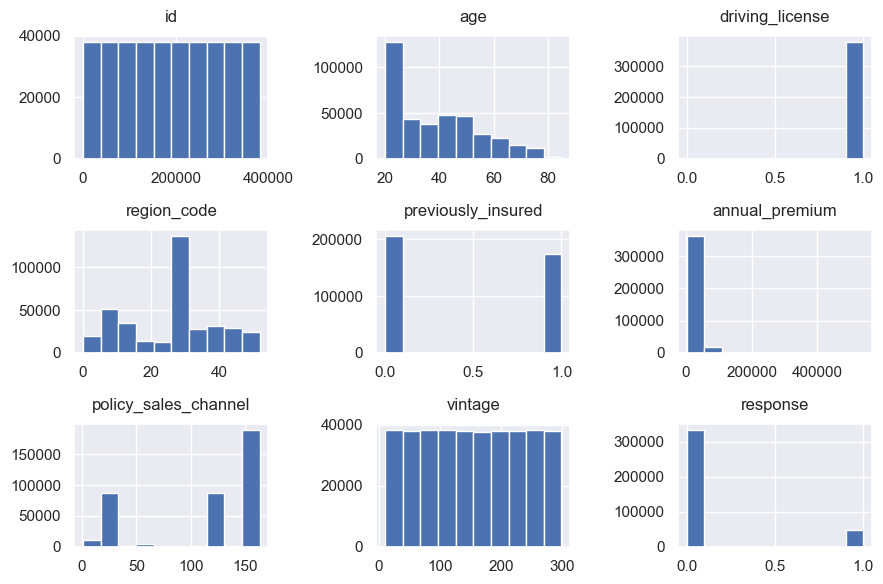

In [22]:
df_num.hist();

In [23]:
df4['region_code'].drop_duplicates().sort_values()

181      0.0
1950     1.0
98       2.0
1        3.0
568      4.0
83       5.0
9        6.0
99       7.0
28       8.0
215      9.0
274     10.0
3       11.0
251     12.0
122     13.0
282     14.0
12      15.0
51      16.0
85      17.0
123     18.0
63      19.0
128     20.0
267     21.0
154     22.0
74      23.0
366     24.0
119     25.0
47      26.0
117     27.0
0       28.0
107     29.0
34      30.0
230     31.0
447     32.0
5       33.0
252     34.0
10      35.0
33      36.0
79      37.0
345     38.0
72      39.0
411     40.0
4       41.0
1480    42.0
414     43.0
166     44.0
16      45.0
108     46.0
55      47.0
58      48.0
133     49.0
11      50.0
1121    51.0
3183    52.0
Name: region_code, dtype: float64

In [24]:
df4['policy_sales_channel'].drop_duplicates().sort_values()

228         1.0
155736      2.0
480         3.0
914         4.0
262746      6.0
          ...  
29        157.0
774       158.0
3662      159.0
5         160.0
23        163.0
Name: policy_sales_channel, Length: 155, dtype: float64

### 4.1.3 Variáveis Categóricas

In [25]:
df_cat.columns

Index(['gender', 'vehicle_age', 'vehicle_damage'], dtype='object')

In [26]:
# valores de gênero
df_cat['gender'].drop_duplicates()

0      Male
4    Female
Name: gender, dtype: object

In [27]:
# valores de idade do veículo
df_cat['vehicle_age'].drop_duplicates()

0    > 2 Years
1     1-2 Year
3     < 1 Year
Name: vehicle_age, dtype: object

In [28]:
# valores de dano
df_cat['vehicle_damage'].drop_duplicates()

0    Yes
1     No
Name: vehicle_damage, dtype: object

<Axes: xlabel='gender', ylabel='count'>

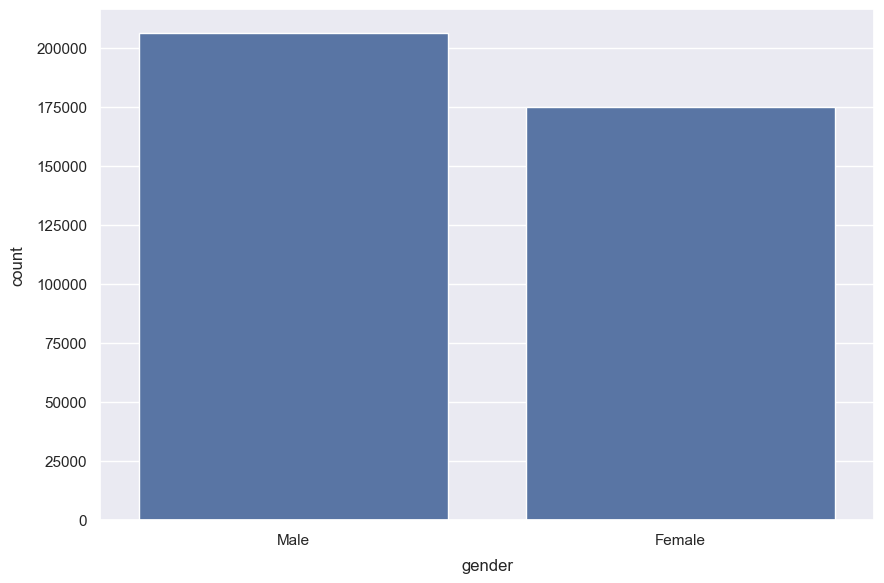

In [29]:
sns.countplot(x=df_cat['gender'])

<Axes: xlabel='vehicle_age', ylabel='count'>

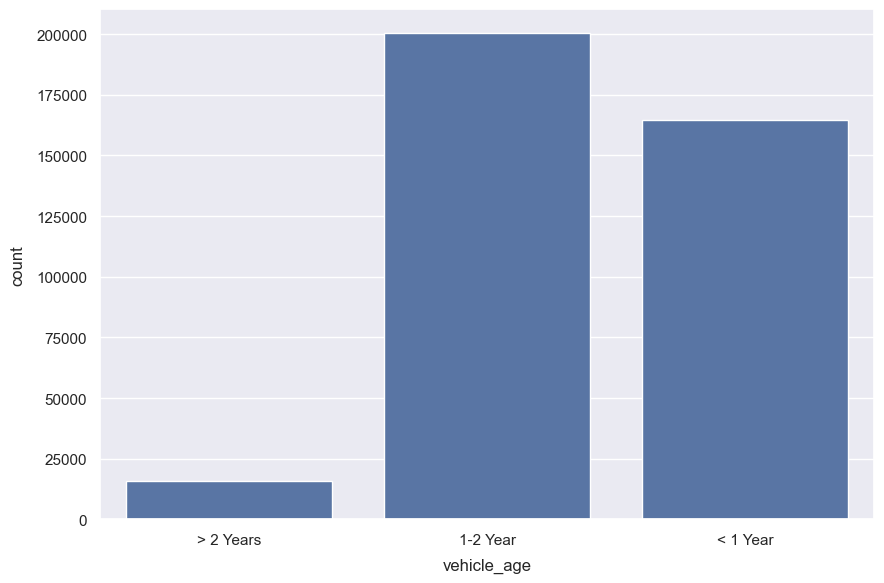

In [30]:
sns.countplot(x=df_cat['vehicle_age'])

<Axes: xlabel='vehicle_damage', ylabel='count'>

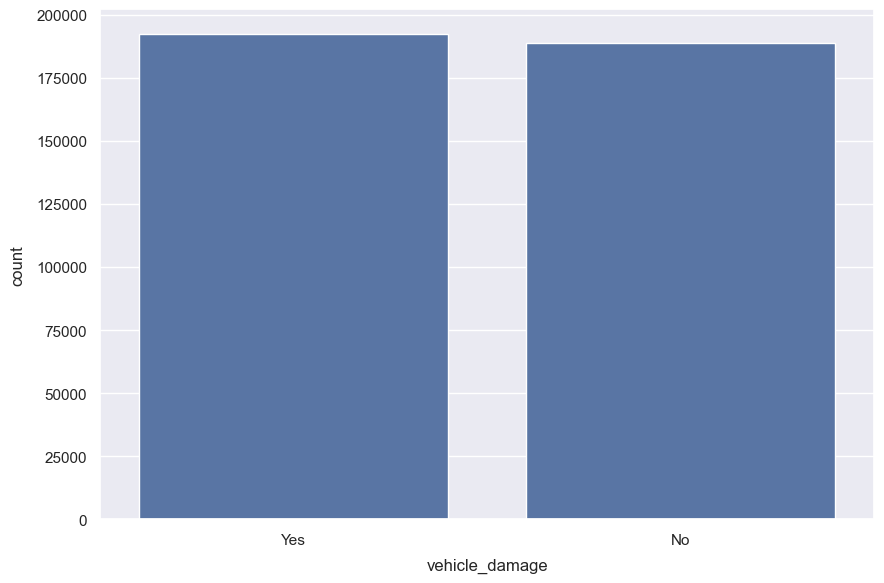

In [31]:
sns.countplot(x=df_cat['vehicle_damage'])

## 4.2 Análise Bivariada

### 4.2.1 Validação de hipóteses

### H1 - Pessoas mais velhas são mais propensas a comprar

Verdadeira. Entre os que compraram, há maior concentração em torno da faixa de 45 anos.

Processo: comparar distribuição de idade entre grupos compradores e não-compradores

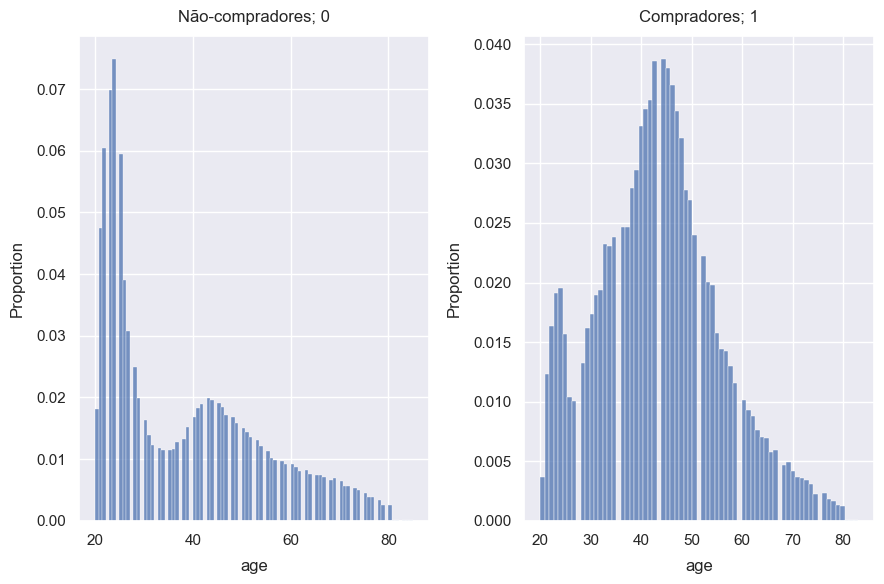

In [32]:
plt.subplot(1,2,1)
aux0 = df4.loc[df4['response'] == 0, 'age']
sns.histplot(aux0, stat='proportion');
plt.title('Não-compradores; 0')
plt.subplot(1,2,2)
aux1 = df4.loc[df4['response'] == 1, 'age']
sns.histplot(aux1, stat='proportion');
plt.title('Compradores; 1');


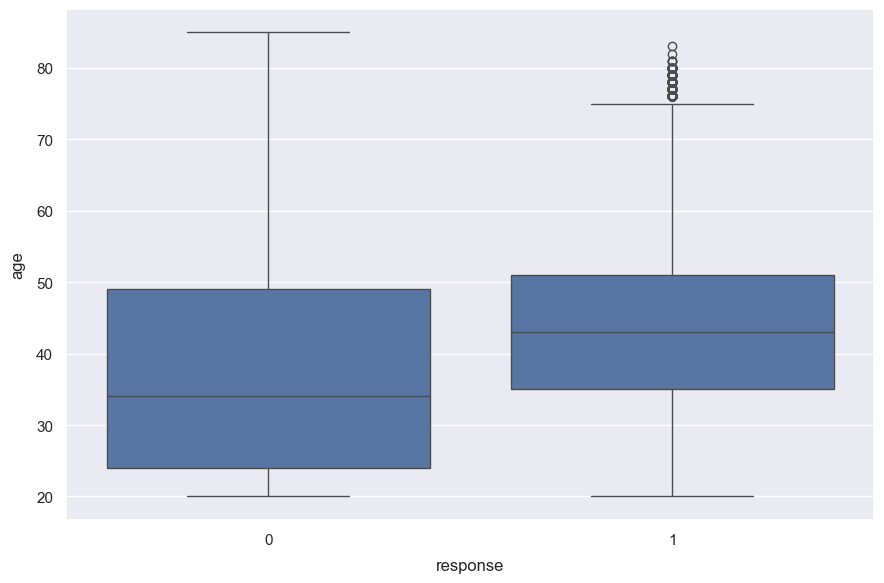

In [33]:
sns.boxplot(df4, x= df4['response'], y= df4['age']);

### Relação age x previously_insured

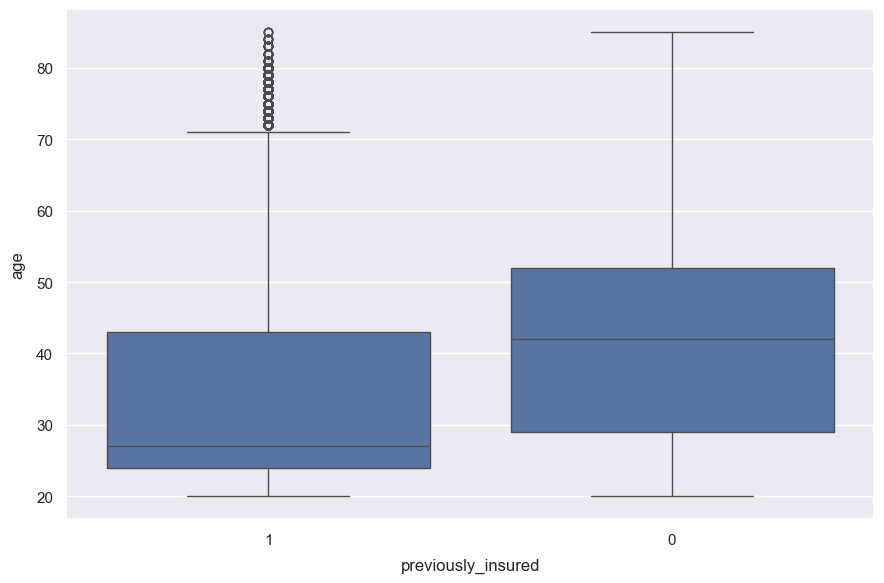

In [34]:
sns.boxplot(data=df4, x=df4['previously_insured'], y=df4['age'], order=['1', '0']);

### H2 - Pessoas do gênero feminino são mais propensas

Falsa. Embora haja uma influência do gênero, homens são mais propensos a comprar.

Processo: comparar proporção entre grupos em função de gênero

Text(0.5, 1.0, 'Compradores; 1')

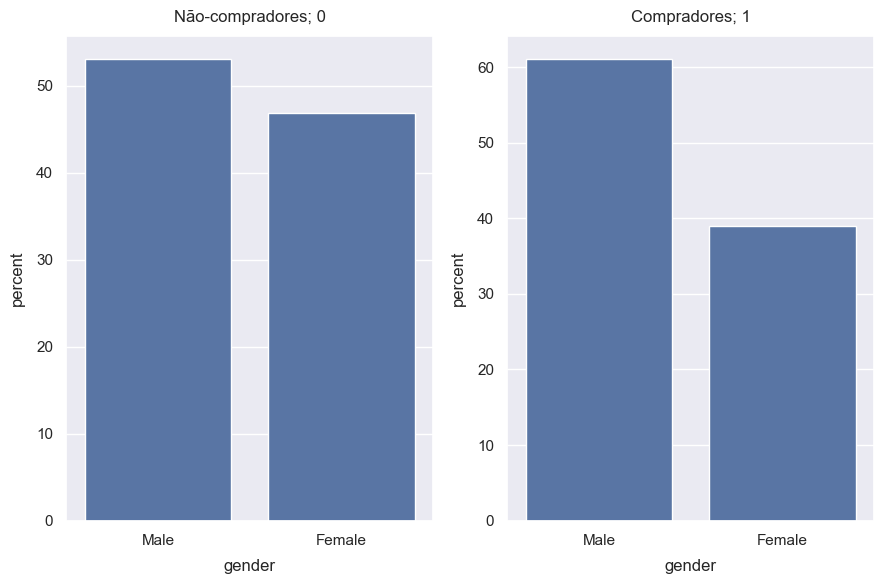

In [35]:
plt.subplot(1,2,1)
aux0 = df4[['response', 'gender']][df4['response']==0]
sns.countplot(x=aux0['gender'], stat='percent');
plt.title('Não-compradores; 0')
plt.subplot(1,2,2)
aux1 = df4[['response', 'gender']][df4['response']==1]
sns.countplot(x=aux1['gender'], stat='percent');
plt.title('Compradores; 1')

### H3 - Pessoas há mais tempo seguradas são mais propensas

Falsa. O tempo de seguro não afeta a propensão

Processo: comparar distribuições

<Axes: xlabel='response', ylabel='vintage'>

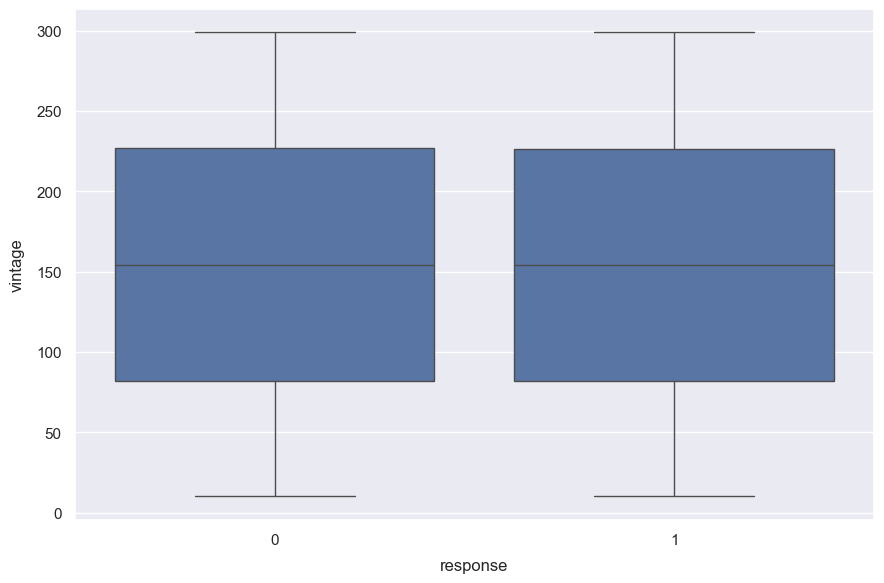

In [36]:
sns.boxplot(df4, x=df4['response'], y=df4['vintage'])

### H4 - Pessoas com maior valor de seguro são mais propensas

Falsa. Embora a mediana do grupo comprador seja um pouco maior que do grupo não-comprador, não parece ser uma diferença significativa

<Axes: xlabel='response', ylabel='annual_premium'>

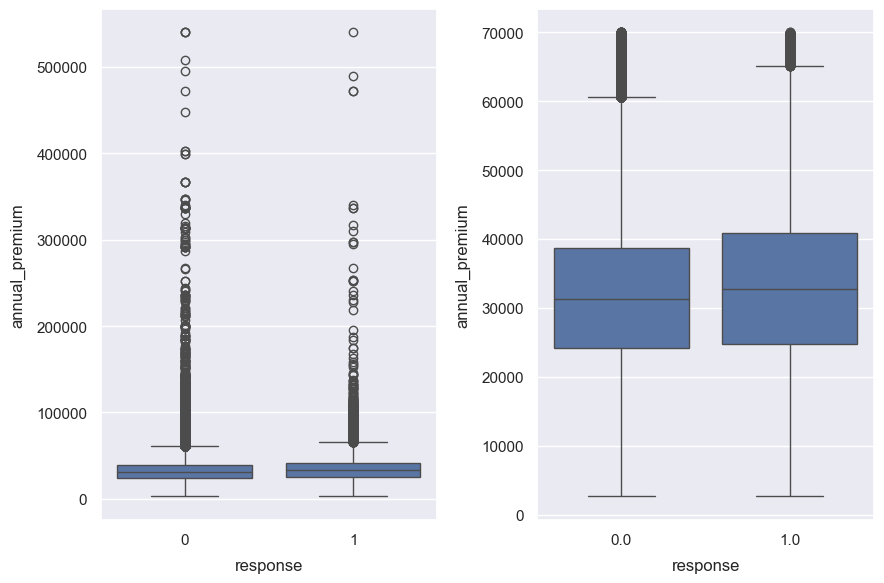

In [37]:
plt.subplot(1,2,1)
sns.boxplot(df4, x=df4['response'], y=df4['annual_premium'])
plt.subplot(1,2,2)
sns.boxplot(df4, x=df4['response'][df4['annual_premium']<70000], y=df4['annual_premium'])

In [38]:
aux = df4.loc[:, ['response', 'annual_premium']].groupby('response').agg(['mean', 'std'])
aux

annual_premium              
                   mean           std
response                             
0          30419.160276  16998.293197
1          31604.092742  18646.508040

### H5 - Clientes com veículos mais novos vão ter maior propensão

Falsa. Embora haja uma concentração de clientes com carros na faixa 1-2 anos que compraram o segundo seguro, 
entre os clientes não-propensos há uma contribuição mais expressiva de clientes com os carros mais novos.

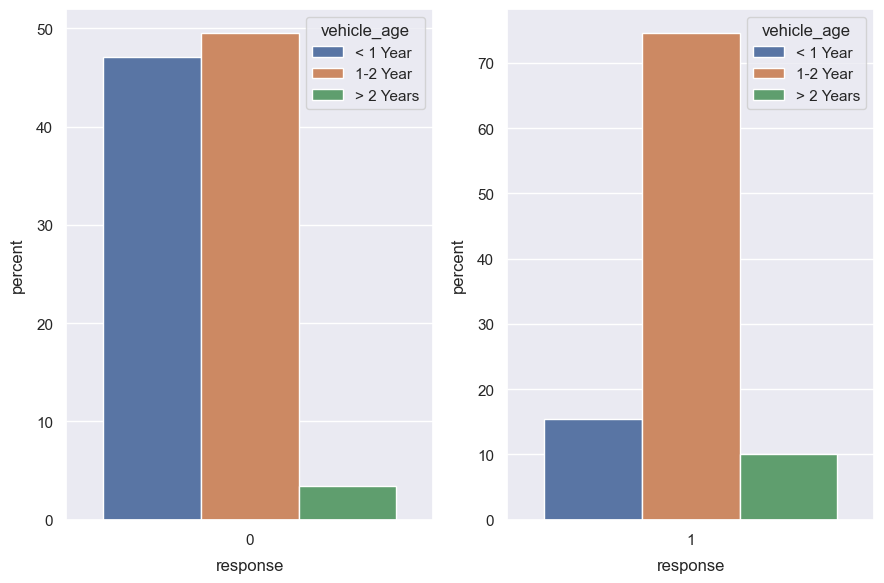

In [39]:
plt.subplot(1,2,1)
aux = df4.loc[df4['response']==0, ['response', 'vehicle_age']]
sns.countplot(aux, x=aux['response'], hue=aux['vehicle_age'], stat='percent',hue_order=['< 1 Year', '1-2 Year', '> 2 Years'])
plt.subplot(1,2,2)
aux = df4.loc[df4['response']==1, ['response', 'vehicle_age']]
sns.countplot(aux, x=aux['response'], hue=aux['vehicle_age'], stat='percent', hue_order=['< 1 Year', '1-2 Year', '> 2 Years']);

### H6 - Clientes que tiveram dano no veículo têm maior propensão

Verdadeira. Dos clientes propensos, quase todos tiveram dano no veículo.

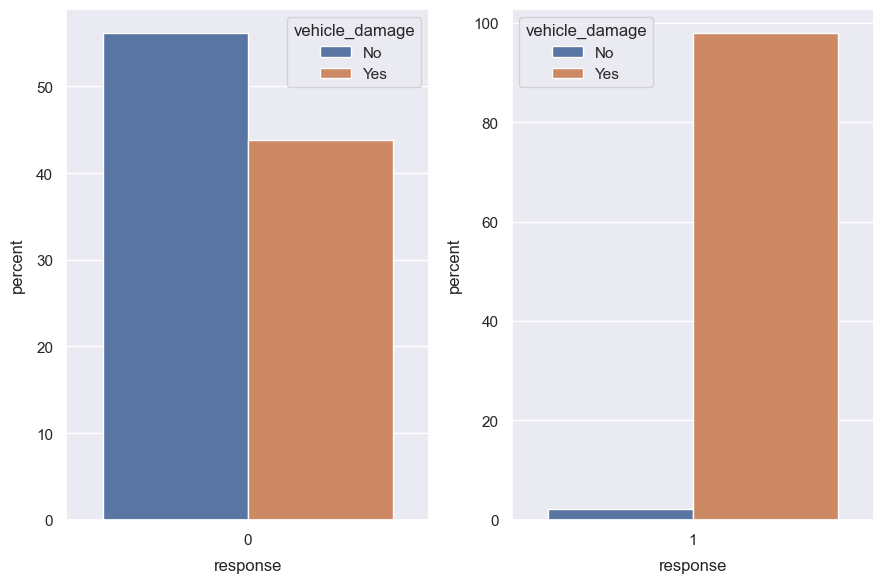

In [40]:
plt.subplot(1,2,1)
aux = df4.loc[df4['response']==0, ['response', 'vehicle_damage']]
sns.countplot(aux, x=aux['response'], hue=aux['vehicle_damage'],stat='percent', hue_order=['No', 'Yes'])
plt.subplot(1,2,2)
aux = df4.loc[df4['response']==1, ['response', 'vehicle_damage']]
sns.countplot(aux, x=aux['response'], hue=aux['vehicle_damage'],stat='percent', hue_order=['No', 'Yes']);

### H7 - Clientes que já possuem seguro têm menos propensão de adquirir outro

Verdadeira. Aqueles que compraram ainda não tinham seguro de carro.

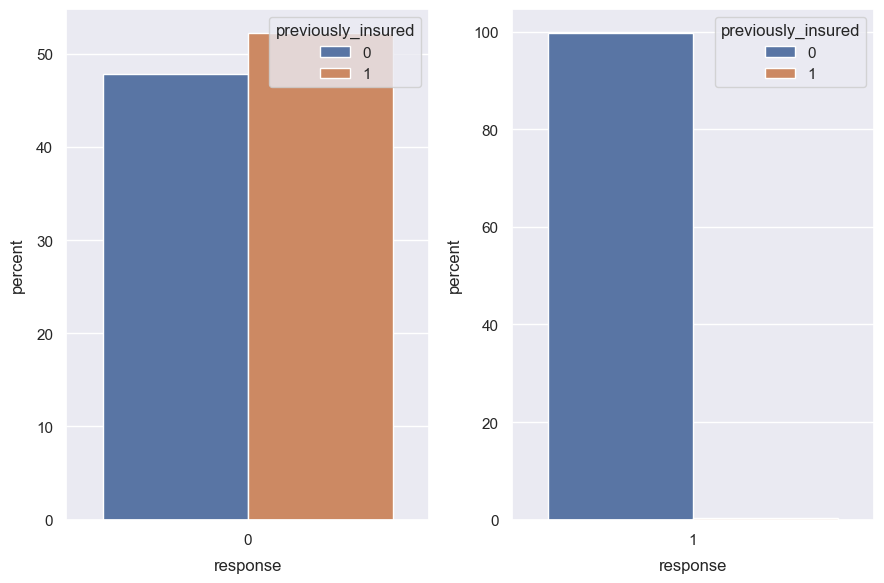

In [41]:
plt.subplot(1,2,1)
aux = df4.loc[df4['response']==0, ['response', 'previously_insured']]
sns.countplot(aux, x=aux['response'], hue=aux['previously_insured'],stat='percent', hue_order=[0, 1])
plt.subplot(1,2,2)
aux = df4.loc[df4['response']==1, ['response', 'previously_insured']]
sns.countplot(aux, x=aux['response'], hue=aux['previously_insured'],stat='percent', hue_order=[0, 1]);

### Investigando código de região e canal de vendas

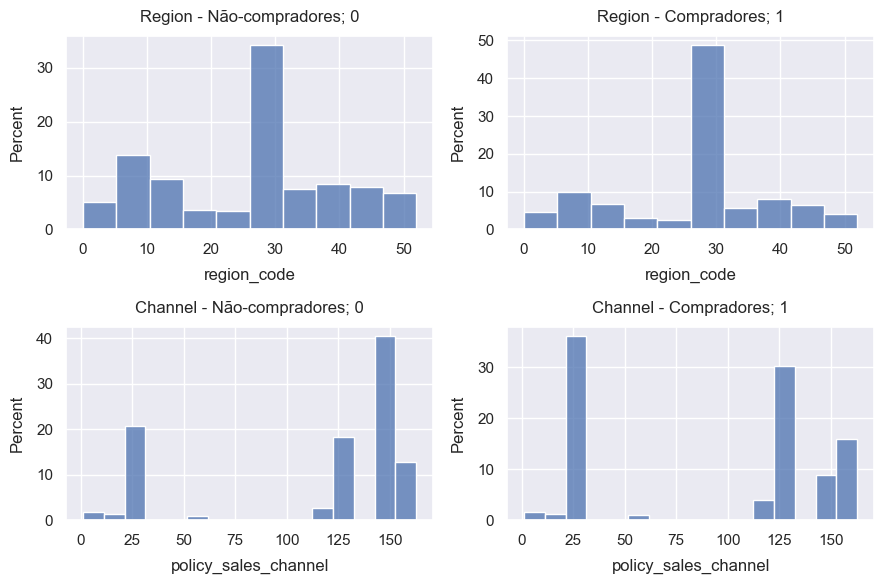

In [42]:
plt.subplot(2,2,1)
aux0 = df4[['response', 'region_code']][df4['response']==0]
sns.histplot(x=aux0['region_code'], stat='percent', bins=10);
plt.title('Region - Não-compradores; 0')
plt.subplot(2,2,2)
aux1 = df4[['response', 'region_code']][df4['response']==1]
sns.histplot(x=aux1['region_code'], stat='percent',bins=10);
plt.title('Region - Compradores; 1')
plt.subplot(2,2,3)
aux2 = df4[['response', 'policy_sales_channel']][df4['response']==0]
sns.histplot(x=aux2['policy_sales_channel'], stat='percent',bins=16);
plt.title('Channel - Não-compradores; 0')
plt.subplot(2,2,4)
aux3 = df4[['response', 'policy_sales_channel']][df4['response']==1]
sns.histplot(x=aux3['policy_sales_channel'], stat='percent',bins=16);
plt.title('Channel - Compradores; 1');

## 4.3 Análise Multivariada

### 4.3.1 Variáveis Numéricas

<Axes: >

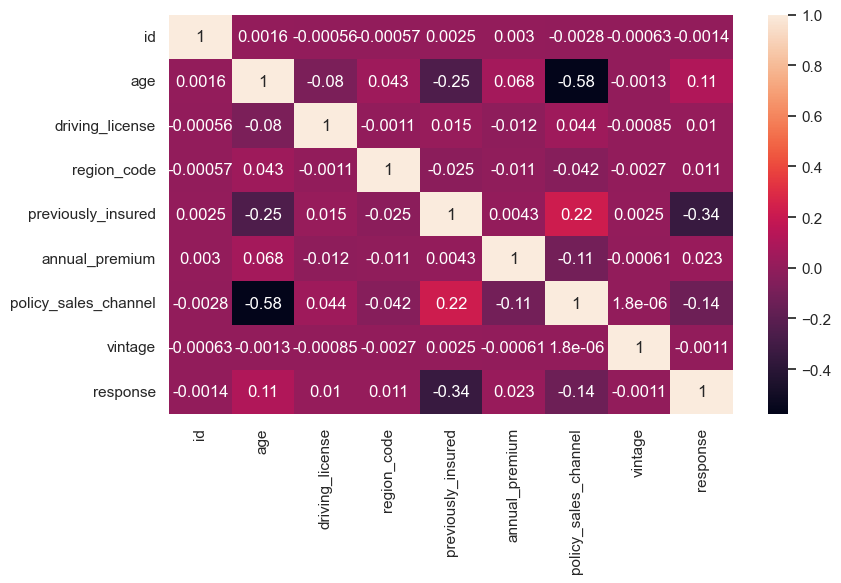

In [43]:
m = df_num.corr(method = 'pearson')
sns.heatmap(m, annot = True)

### 4.3.2 Variáveis Categóricas

In [44]:
df_cat.columns

Index(['gender', 'vehicle_age', 'vehicle_damage'], dtype='object')

In [45]:
cont = pd.crosstab(df_cat['gender'], df_cat['vehicle_age'])
cont

vehicle_age,1-2 Year,< 1 Year,> 2 Years
gender,,,
Female,77992,91321,5707
Male,122324,73465,10300


In [46]:
v = association(cont, correction = True)
v

0.16678591473071144

In [47]:
def cramer_v(x, y):
    cont = pd.crosstab(x, y)
    v = association(cont, method = 'cramer', correction = True)
    return v

In [48]:
# gender
v1 = cramer_v(df_cat['gender'], df_cat['gender'])
v2 = cramer_v(df_cat['gender'], df_cat['vehicle_age'])
v3 = cramer_v(df_cat['gender'], df_cat['vehicle_damage'])
# vehicle age
v4 = cramer_v(df_cat['vehicle_age'], df_cat['gender'])
v5 = cramer_v(df_cat['vehicle_age'], df_cat['vehicle_age'])
v6 = cramer_v(df_cat['vehicle_age'], df_cat['vehicle_damage'])
# vehicle damage
v7 = cramer_v(df_cat['vehicle_damage'], df_cat['gender'])
v8 = cramer_v(df_cat['vehicle_damage'], df_cat['vehicle_age'])
v9 = cramer_v(df_cat['vehicle_damage'], df_cat['vehicle_damage'])

d = pd.DataFrame({
    'gender': [v1,v2,v3],
    'vehicle_age': [v4,v5,v6],
    'vehicle_damage': [v7,v8,v9]
})
d = d.set_index(d.columns)

<Axes: >

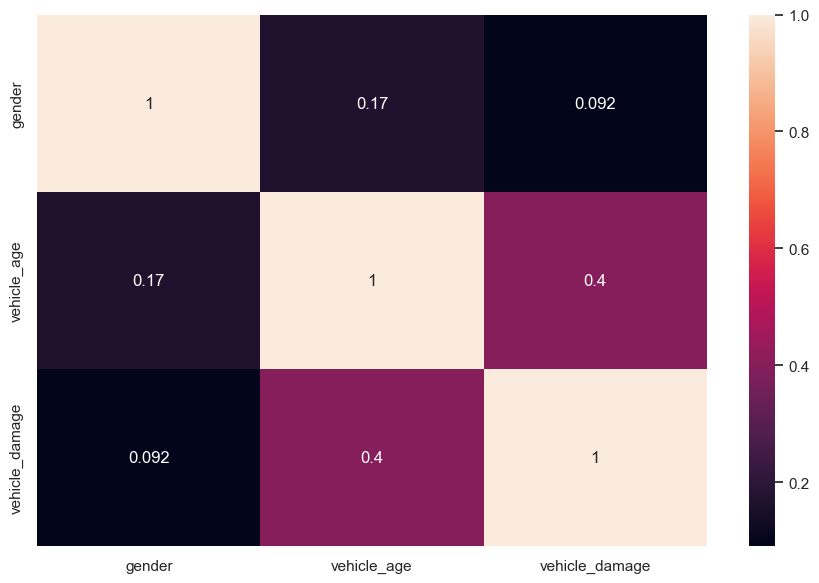

In [49]:
sns.heatmap(d, annot=True)

### Resultados da análise:

Observações sobre negócio:

* Se já tinha seguro veicular, então menos chance de comprar outro
* Se já tem seguro veicular, então o cliente deve ser mais jovem
* Se o cliente é mais jovem, então menos propensão de compra

Logo, se quero oferecer seguro veicular para quem já possui seguro de vida, devo procurar os clientes mais velhos(faixa dos 45 anos).
E a possível causa é que eles não possuem seguro veicular.

* Qual a causa de não terem seguro veicular? Hipótese:
    - H1: Possuem despesas com família e preferem priorizar o seguro de vida em vez de seguro veicular
    - H2: Já têm experiência em dirigir e não percebem necessidade de seguro, acham que não vale a pena.

Observações sobre machine learning:

* Não foram observadas features altamente correlacionadas que pudessem gerar risco de overfitting
* A feature vintage não possui um comportamento bem definido e não possui correlação com as demais; é candidata a ser removida.

# 5.0 Preparação dos Dados

* Rescaling
    - age: min max scaler
    - vintage: min max scaler
    - annual_premium: robust scaler
    
* Encoding
    - region_code: target encoding
    - policy_sales_channel: target encoding
    - gender: ordinal encoding(0, 1)
    - vehicle_age: ordinal encoding(0,1,2)
    - vehicle_damage: ordinal encoding(0,1)

In [23]:
df5 = df4.copy()

In [24]:
# divisão do dataset

X = df5.drop(columns='response')
y = df5['response']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y, random_state = 42)

In [25]:
#reservando dados brutos para teste da API
#df_test_raw = pd.concat([X_test, y_test], axis=1 )
df_test_raw = X_test.copy()

## 5.1 Rescaling

In [63]:
age_mms = MinMaxScaler()
vintage_mms = MinMaxScaler()
annual_premium_rs = RobustScaler()

In [64]:
X_train['age'] = age_mms.fit_transform(X_train[['age']])
pickle.dump(age_mms, open('src/features/age_scaler.pkl', 'wb'))
X_train['vintage'] = vintage_mms.fit_transform(X_train[['vintage']])
pickle.dump(vintage_mms, open('src/features/vintage_scaler.pkl', 'wb'))
X_train['annual_premium'] = annual_premium_rs.fit_transform(X_train[['annual_premium']])
pickle.dump(annual_premium_rs, open('src/features/annual_premium_scaler.pkl', 'wb'))

## 5.2 Encoding

In [65]:
gender_enc = OrdinalEncoder()
vehicle_damage_enc = OrdinalEncoder()
vehicle_age_enc = OrdinalEncoder(categories = [['< 1 Year', '1-2 Year', '> 2 Years']])

In [66]:
# ordinal
X_train['gender'] = gender_enc.fit_transform(X_train[['gender']])
pickle.dump(gender_enc, open('src/features/gender_scaler.pkl', 'wb'))
X_train['vehicle_damage'] = vehicle_damage_enc.fit_transform(X_train[['vehicle_damage']])
pickle.dump(vehicle_damage_enc, open('src/features/vehicle_damage_scaler.pkl', 'wb'))
X_train['vehicle_age'] = vehicle_age_enc.fit_transform(X_train[['vehicle_age']])
pickle.dump(vehicle_age_enc, open('src/features/vehicle_age_scaler.pkl', 'wb'))

### 5.2.1 Target encoding

In [67]:
# instanciando encoder
region_enc = TargetEncoder(cv=5, target_type='binary', smooth=3)
policy_enc = TargetEncoder(cv=5, target_type='binary', smooth=5)


In [68]:
#usando objetos
X_train[['region_code']] = region_enc.fit_transform(X_train[['region_code']], y_train)
pickle.dump(region_enc, open('src/features/region_code_scaler.pkl', 'wb'))
X_train[['policy_sales_channel']] = policy_enc.fit_transform(X_train[['policy_sales_channel']], y_train)
pickle.dump(policy_enc, open('src/features/policy_sales_channel_scaler.pkl', 'wb'))

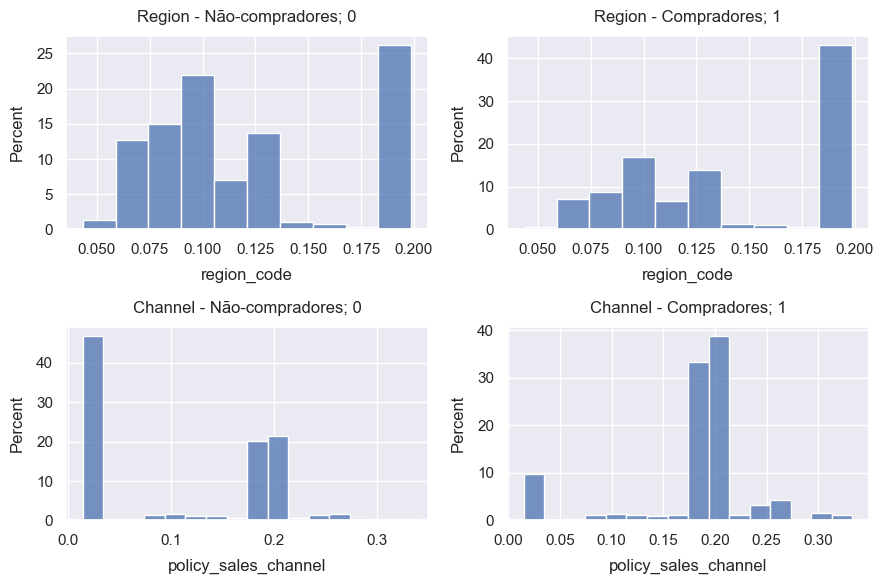

In [69]:
#avaliando resultado do target encoding
plt.subplot(2,2,1)
aux0 = X_train[[ 'region_code']][y_train==0]
sns.histplot(x=aux0['region_code'], stat='percent', bins=10);
plt.title('Region - Não-compradores; 0')
plt.subplot(2,2,2)
aux1 = X_train[[ 'region_code']][y_train==1]
sns.histplot(x=aux1['region_code'], stat='percent',bins=10);
plt.title('Region - Compradores; 1')
plt.subplot(2,2,3)
aux2 = X_train[[ 'policy_sales_channel']][y_train==0]
sns.histplot(x=aux2['policy_sales_channel'], stat='percent',bins=16);
plt.title('Channel - Não-compradores; 0')
plt.subplot(2,2,4)
aux3 = X_train[[ 'policy_sales_channel']][y_train==1]
sns.histplot(x=aux3['policy_sales_channel'], stat='percent',bins=16);
plt.title('Channel - Compradores; 1');

## 5.3 Preparando dados de teste

In [70]:
# rescaling
X_test['age'] = age_mms.transform(X_test[['age']])
X_test['vintage'] = vintage_mms.transform(X_test[['vintage']])
X_test['annual_premium'] = annual_premium_rs.transform(X_test[['annual_premium']])

In [71]:
# ordinal
X_test['gender'] = gender_enc.transform(X_test[['gender']])
X_test['vehicle_damage'] = vehicle_damage_enc.transform(X_test[['vehicle_damage']])
X_test['vehicle_age'] = vehicle_age_enc.transform(X_test[['vehicle_age']])

In [72]:
#Aplicando target encoder aos dados de teste
X_test['policy_sales_channel'] = policy_enc.transform(X_test[['policy_sales_channel']])
X_test['region_code'] = region_enc.transform(X_test[['region_code']])

In [73]:
# armazenando id
id_train = X_train[['id']]
id_test = X_test[['id']]
id_train.head()

,id
274710,274711
216539,216540
78983,78984
218368,218369
307215,307216


In [74]:
# removendo id
X_train = X_train.drop(['id'], axis = 1)
X_test = X_test.drop(['id'], axis = 1)
X_train.sample(50)

,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage
112079,0.0,0.446154,1,0.074820,0,1.0,0.0,-0.053125,0.200620,0.792388
266014,1.0,0.046154,1,0.093858,1,0.0,0.0,0.658444,0.029095,0.799308
196256,0.0,0.892308,1,0.187917,0,1.0,0.0,0.047340,0.126815,0.757785
108278,1.0,0.061538,1,0.075717,1,0.0,0.0,-0.488032,0.028857,0.446367
309596,0.0,0.107692,1,0.094003,0,0.0,1.0,-0.011037,0.028857,0.224913
356825,0.0,0.046154,1,0.074506,0,0.0,1.0,-1.932646,0.021313,0.674740
87902,0.0,0.923077,1,0.187917,0,1.0,1.0,0.121410,0.189330,0.737024
203283,0.0,0.369231,1,0.095736,0,1.0,0.0,0.253524,0.199667,0.906574
24926,1.0,0.015385,1,0.078877,0,0.0,1.0,0.793019,0.021408,0.456747
293494,1.0,0.076923,1,0.101823,1,0.0,0.0,-0.524402,0.028426,0.754325


# 6.0 Feature Selection

## 6.1 Usando Boruta

In [182]:
# escolhendo random forest pra seleção
rf = RandomForestClassifier(n_jobs=-1)
boruta = BorutaPy(rf, n_estimators='auto', verbose= 2, random_state=42)

In [183]:
%%time
boruta.fit(X_train, y_train)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	10
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	10
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	10
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	10
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	10
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	10
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	10
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	0
Tentative: 	2
Rejected: 	8
Iteration: 	9 / 100
Confirmed: 	0
Tentative: 	2
Rejected: 	8
Iteration: 	10 / 100
Confirmed: 	0
Tentative: 	2
Rejected: 	8
Iteration: 	11 / 100
Confirmed: 	0
Tentative: 	2
Rejected: 	8
Iteration: 	12 / 100
Confirmed: 	0
Tentative: 	2
Rejected: 	8
Iteration: 	13 / 100
Confirmed: 	0
Tentative: 	2
Rejected: 	8
Iteration: 	14 / 100
Confirmed: 	0
Tentative: 	2
Rejected: 	8
Iteration: 	15 / 100
Confirmed: 	0
Tentative: 	2
Rejected: 	8
Iteration: 	16 / 100
Confirmed: 	0
Tentative: 	2
Rejected: 	8
Iteration:

BorutaPy(estimator=RandomForestClassifier(n_estimators=20, n_jobs=-1,
                                          random_state=RandomState(MT19937) at 0x1EBB1F31240),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x1EBB1F31240, verbose=2)

In [184]:
cols_selected = boruta.support_.tolist()
cols_selected

[False, True, False, False, False, False, False, False, False, False]

In [187]:
#cols_old = [False, False, True, False, False, False, False, False, False, True, False]
cols = [False, True, False, False, False, False, False, False, False, False]

In [188]:
cols_selected_boruta = X_train.iloc[:, cols].columns.tolist()
cols_selected_boruta

['age']

In [191]:
boruta.ranking_

array([ 9,  1, 10,  5,  7,  8,  6,  4,  3,  2])

In [192]:
#ordenando features
ranking = [ 9,  1, 10,  5,  7,  8,  5,  4,  3,  2]
cols = X_train.columns

cols_ordered =  [cols[i] for i in [k-1 for k in ranking]]
cols_ordered

['policy_sales_channel',
 'gender',
 'vintage',
 'previously_insured',
 'vehicle_damage',
 'annual_premium',
 'previously_insured',
 'region_code',
 'driving_license',
 'age']

In [193]:
c_r = list(zip(cols, ranking))
ordered = sorted(c_r, key=lambda x: x[1])
ordered

[('age', 1),
 ('vintage', 2),
 ('policy_sales_channel', 3),
 ('annual_premium', 4),
 ('region_code', 5),
 ('vehicle_damage', 5),
 ('previously_insured', 7),
 ('vehicle_age', 8),
 ('gender', 9),
 ('driving_license', 10)]

In [194]:
cols_ordered_boruta = [i[0] for i in ordered]
cols_ordered_boruta

['age',
 'vintage',
 'policy_sales_channel',
 'annual_premium',
 'region_code',
 'vehicle_damage',
 'previously_insured',
 'vehicle_age',
 'gender',
 'driving_license']

## 6.2 Importância de features

### 6.2.1 Extra Trees

In [195]:
%%time
etc = ExtraTreesClassifier()
etc.fit(X_train, y_train)

CPU times: total: 14.9 s
Wall time: 3min 10s


ExtraTreesClassifier()

In [196]:
etc.feature_importances_

array([0.00512186, 0.13578318, 0.00047522, 0.16328684, 0.04571689,
       0.01380762, 0.08136025, 0.17566058, 0.17705388, 0.20173369])

In [197]:
importances = [0.00483203, 0.13085419, 0.00047609, 0.1612635 , 0.04984369,
       0.01276608, 0.07998121, 0.1764827 , 0.17923872, 0.20426181]
cols = X_train.columns
c_i = list(zip(cols,importances))
ordered = sorted(c_i, key=lambda x: x[1], reverse=True)
cols_ordered_xtrees = [i[0] for i in ordered]
cols_ordered_xtrees

['vintage',
 'policy_sales_channel',
 'annual_premium',
 'region_code',
 'age',
 'vehicle_damage',
 'previously_insured',
 'vehicle_age',
 'gender',
 'driving_license']

In [198]:
X_train.columns

Index(['gender', 'age', 'driving_license', 'region_code', 'previously_insured',
       'vehicle_age', 'vehicle_damage', 'annual_premium',
       'policy_sales_channel', 'vintage'],
      dtype='object')

### 6.2.2 Logistc Regression

In [199]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression()

In [200]:
lr.coef_

array([[ 0.07019599, -1.34334783,  0.58807955,  2.40683143, -3.84465376,
         0.31542235,  1.93343707,  0.04554029,  6.07684087, -0.0134245 ]])

In [201]:
c_i = list(zip(X_train.columns, lr.coef_[0]))
ordered = sorted(c_i, key=lambda x: abs(x[1]), reverse=True)
cols_ordered_lr = [i[0] for i in ordered]
cols_ordered_lr

['policy_sales_channel',
 'previously_insured',
 'region_code',
 'vehicle_damage',
 'age',
 'driving_license',
 'vehicle_age',
 'gender',
 'annual_premium',
 'vintage']

## 6.3 Resultado

As features 'driving_license', 'vehicle_age' e 'gender' foram excluídas pois se mostraram menos importantes para o boruta e para os modelos, além de não apresentarem padrão muito claro na EDA.

In [1]:
cols_selected = ['policy_sales_channel',
 'previously_insured',
 'region_code',
 'vehicle_damage',
 'age',
 'annual_premium',
 'vintage']

# 7.0 Machine Learning

In [75]:
X_train = X_train[cols_selected]
X_test = X_test[cols_selected]

### 7.0.1 Balanceamento

In [76]:
# fazendo Balanceamento SMOTE
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

### 7.0.2 PCA

In [77]:
#PCA
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [78]:
df_pca = pd.DataFrame( X_train_pca)
df_pca = pd.concat([df_pca, y_train], axis=1)
df_pca.head()

,0,1,response
0,-0.343401,-0.635738,1.0
1,0.513527,0.753402,0.0
2,0.102675,-0.661424,NaN
3,0.473224,-0.648232,0.0
4,1.203408,-0.643616,0.0


<Axes: xlabel='0', ylabel='1'>

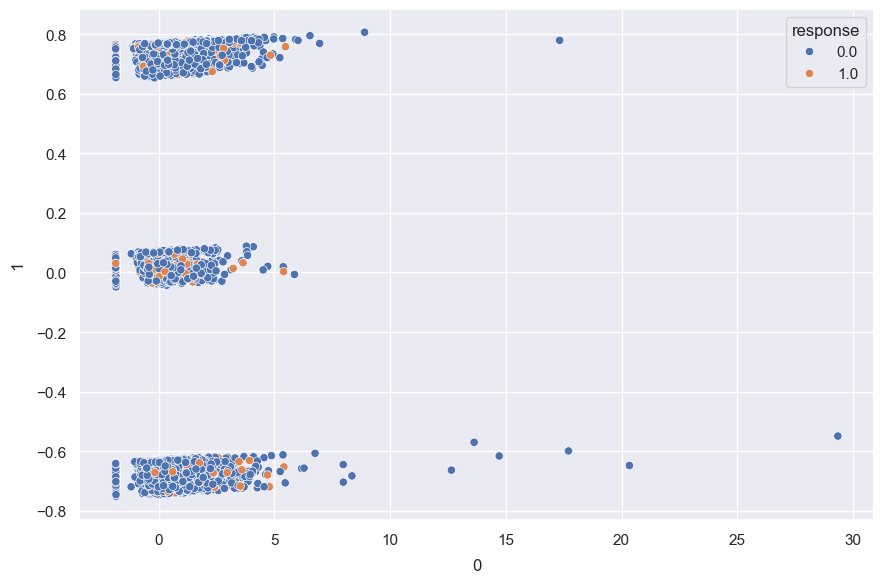

In [79]:
sns.scatterplot(df_pca.sample(30000), x=0, y=1 , hue = 'response' )

É possivel observar separação de grupos. Poderia rodar Kmeans para encontrar clusters e criar uma nova feature que pudesse ajudar os modelos.

## 7.1 KNN

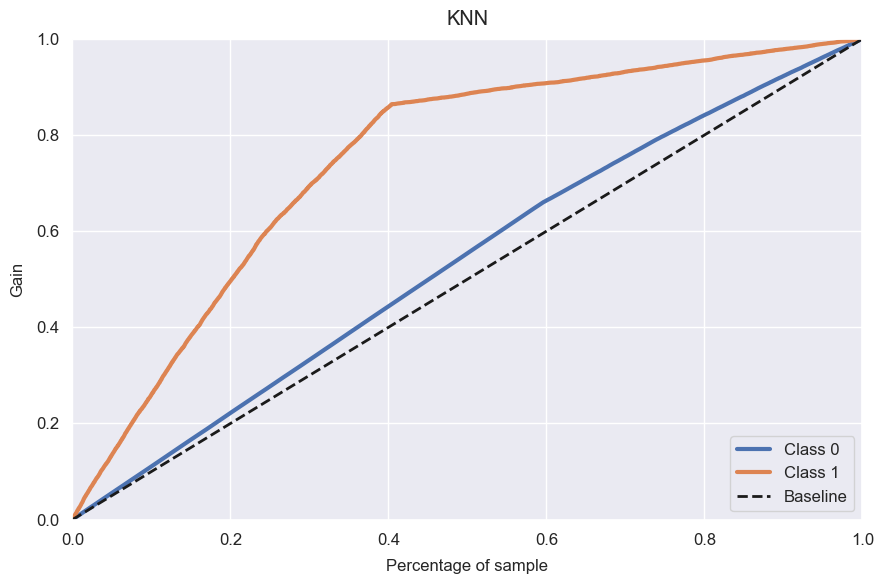

In [80]:
knn_model = nh.KNeighborsClassifier(7, n_jobs=-1)

knn_model.fit(X_train, y_train)

yhat_knn = knn_model.predict_proba(X_test)

# Cumulative Gain
skplt.metrics.plot_cumulative_gain(y_test, yhat_knn, title='KNN' );

<Axes: title={'center': 'KNN - SMOTE'}, xlabel='Percentage of sample', ylabel='Gain'>

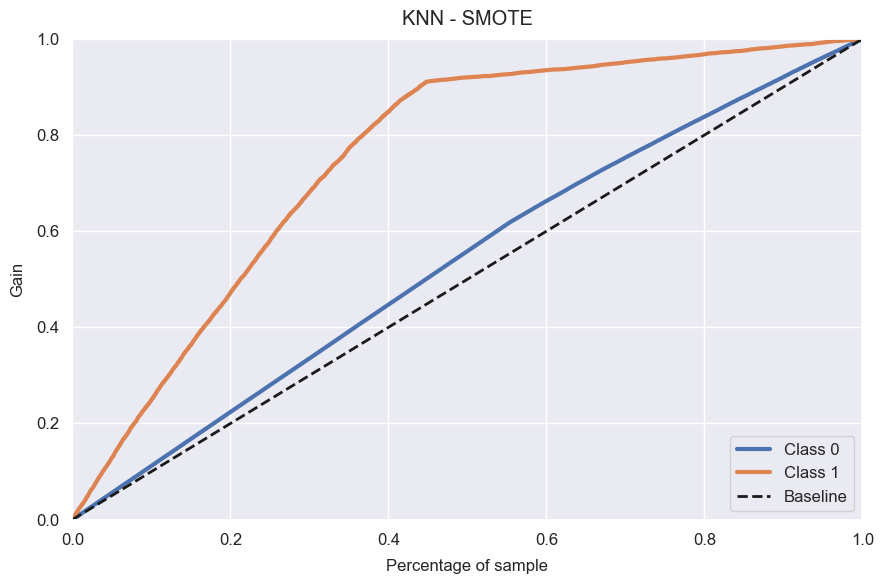

In [81]:
knn_model_bal = nh.KNeighborsClassifier(n_neighbors=7)
knn_model_bal.fit(X_train_bal,y_train_bal)
yhat_knn_bal = knn_model_bal.predict_proba(X_test)
skplt.metrics.plot_cumulative_gain(y_test, yhat_knn_bal, title='KNN - SMOTE')

<Axes: title={'center': 'KNN - PCA'}, xlabel='Percentage of sample', ylabel='Gain'>

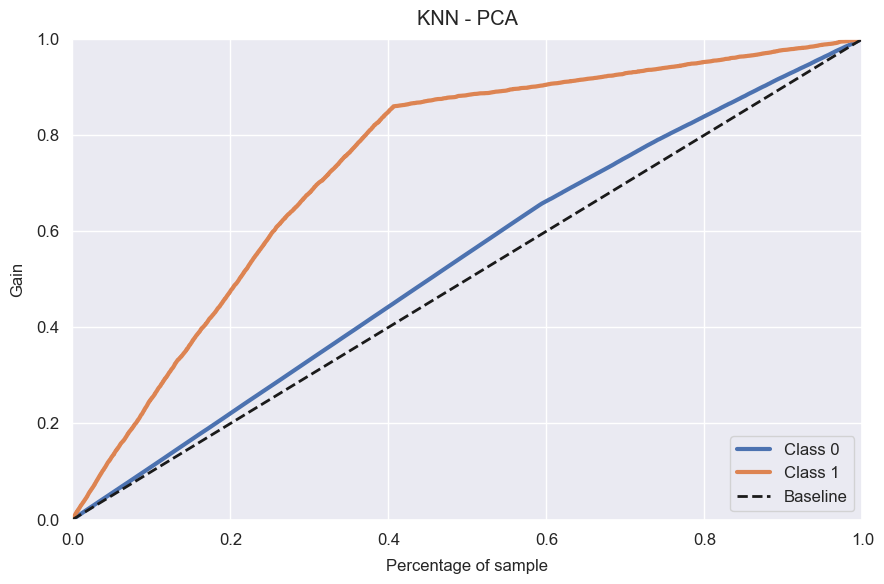

In [82]:
knn_model_pca = nh.KNeighborsClassifier(n_neighbors=7)
knn_model_pca.fit(X_train_pca,y_train)
yhat_knn_pca = knn_model_pca.predict_proba(X_test_pca)
skplt.metrics.plot_cumulative_gain(y_test, yhat_knn_pca, title='KNN - PCA')

## 7.2 Logistic Regression

C:\ProgramData\anaconda3\envs\pa004_311\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


<Axes: title={'center': 'Logistic Regression'}, xlabel='Percentage of sample', ylabel='Gain'>

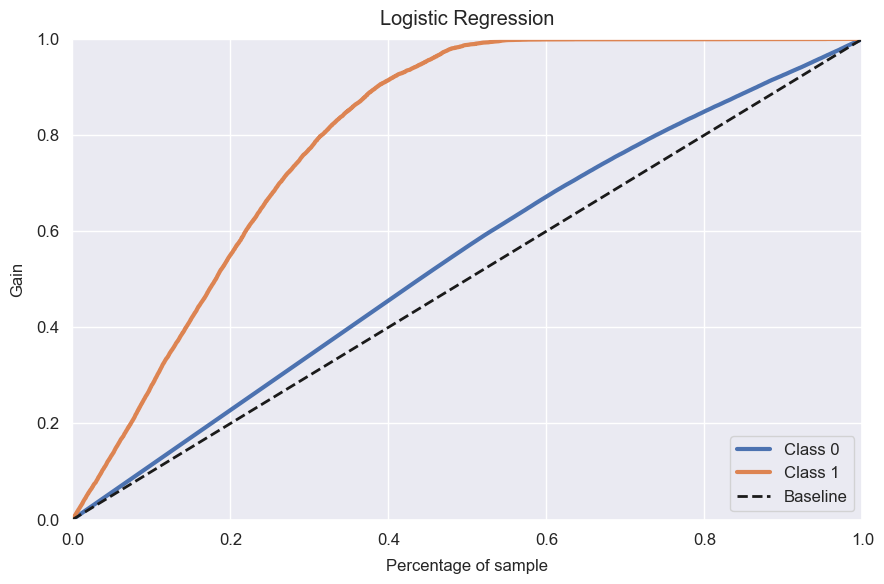

In [83]:
lr_model = LogisticRegression(solver = 'saga', penalty='l1', C=0.5, l1_ratio=0.5, random_state=42, class_weight = 'balanced')

lr_model.fit(X_train, y_train)
yhat_lr = lr_model.predict_proba(X_test)

skplt.metrics.plot_cumulative_gain(y_test, yhat_lr, title='Logistic Regression')

<Axes: title={'center': 'Logistic Regression - SMOTE'}, xlabel='Percentage of sample', ylabel='Gain'>

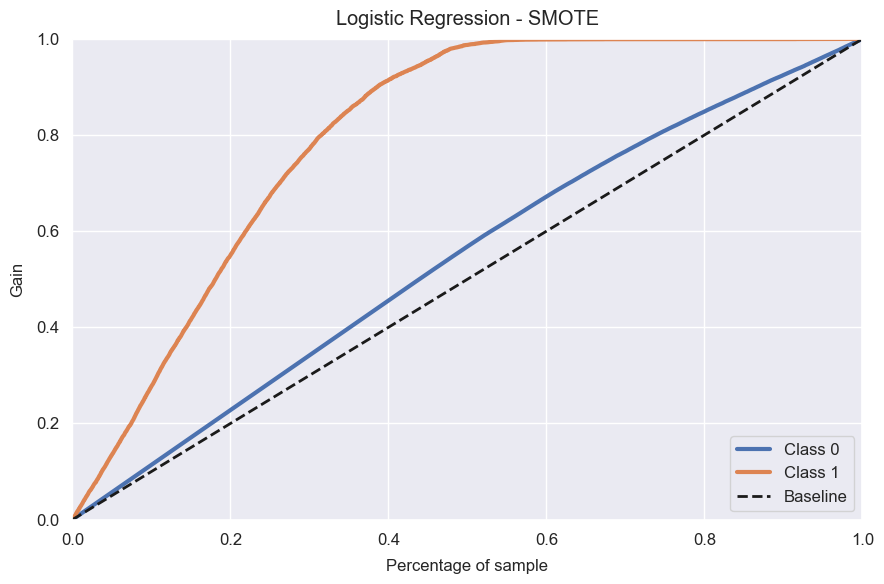

In [84]:
lr_model_bal = LogisticRegression(random_state=42)

lr_model_bal.fit(X_train_bal, y_train_bal)
yhat_lr_bal = lr_model_bal.predict_proba(X_test)

skplt.metrics.plot_cumulative_gain(y_test, yhat_lr_bal, title='Logistic Regression - SMOTE')

<Axes: title={'center': 'Logistic Regression - PCA'}, xlabel='Percentage of sample', ylabel='Gain'>

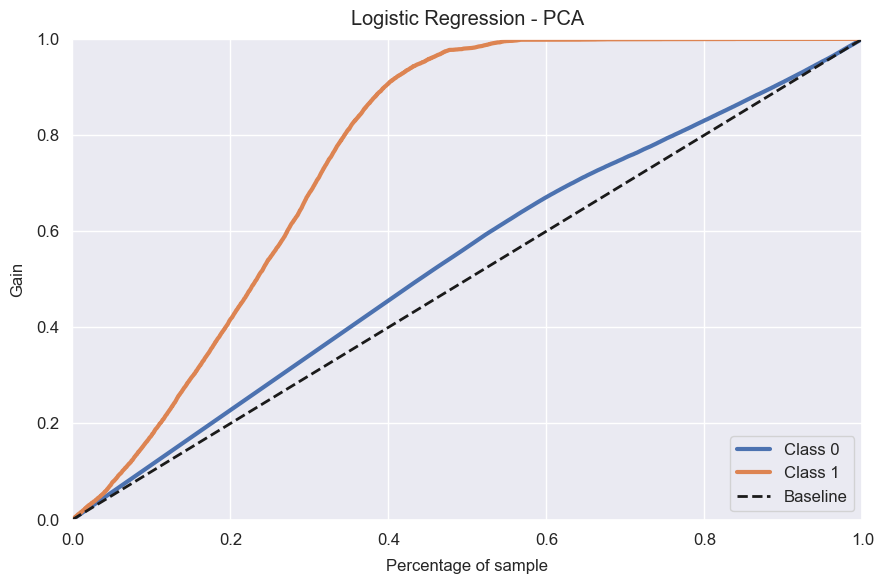

In [85]:
lr_model_pca = LogisticRegression(random_state=42)

lr_model_pca.fit(X_train_pca, y_train)
yhat_lr_pca = lr_model_pca.predict_proba(X_test_pca)

skplt.metrics.plot_cumulative_gain(y_test, yhat_lr_pca, title='Logistic Regression - PCA')

## 7.3 Extra Trees

<Axes: title={'center': 'Extra Trees'}, xlabel='Percentage of sample', ylabel='Gain'>

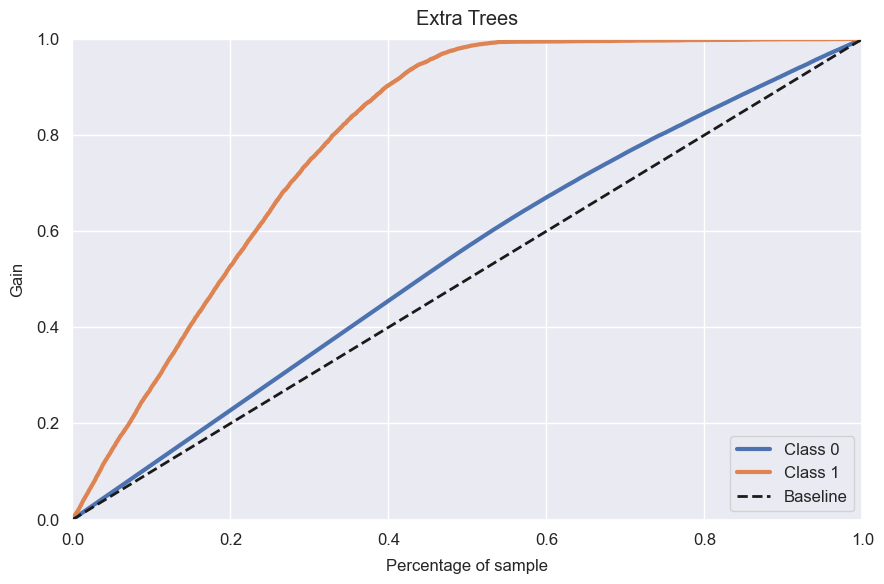

In [86]:
et_model = ExtraTreesClassifier(class_weight='balanced')

et_model.fit(X_train, y_train)

yhat_et = et_model.predict_proba(X_test)

skplt.metrics.plot_cumulative_gain(y_test, yhat_et, title='Extra Trees')

<Axes: title={'center': 'Extra Trees - SMOTE'}, xlabel='Percentage of sample', ylabel='Gain'>

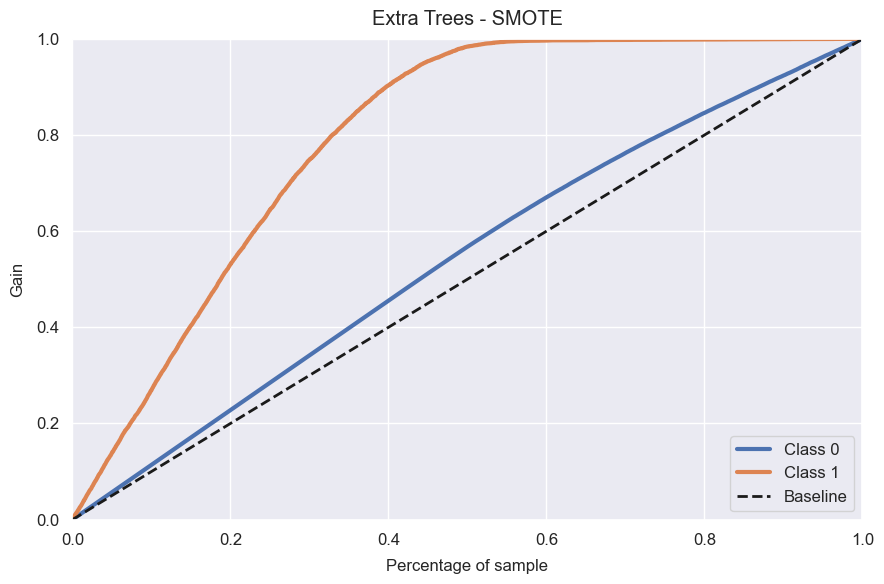

In [89]:
et_model_bal = ExtraTreesClassifier()

et_model_bal.fit(X_train_bal, y_train_bal)

yhat_et_bal = et_model_bal.predict_proba(X_test)

skplt.metrics.plot_cumulative_gain(y_test, yhat_et_bal, title='Extra Trees - SMOTE')

<Axes: title={'center': 'Extra Trees - PCA'}, xlabel='Percentage of sample', ylabel='Gain'>

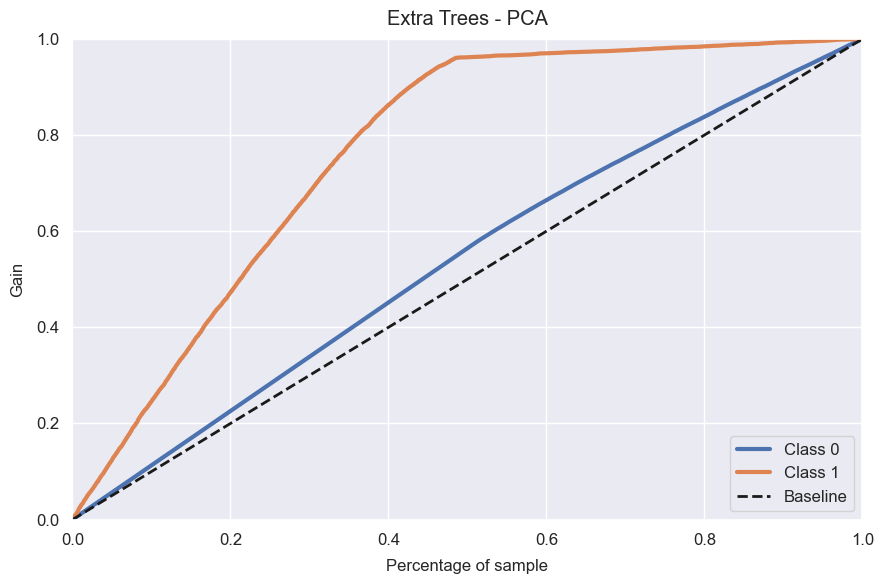

In [90]:
et_model_pca = ExtraTreesClassifier()

et_model_pca.fit(X_train_pca, y_train)

yhat_et_pca = et_model_pca.predict_proba(X_test_pca)

skplt.metrics.plot_cumulative_gain(y_test, yhat_et_pca, title='Extra Trees - PCA')

## 7.4 Random Forest

<Axes: title={'center': 'Random Forest'}, xlabel='Percentage of sample', ylabel='Gain'>

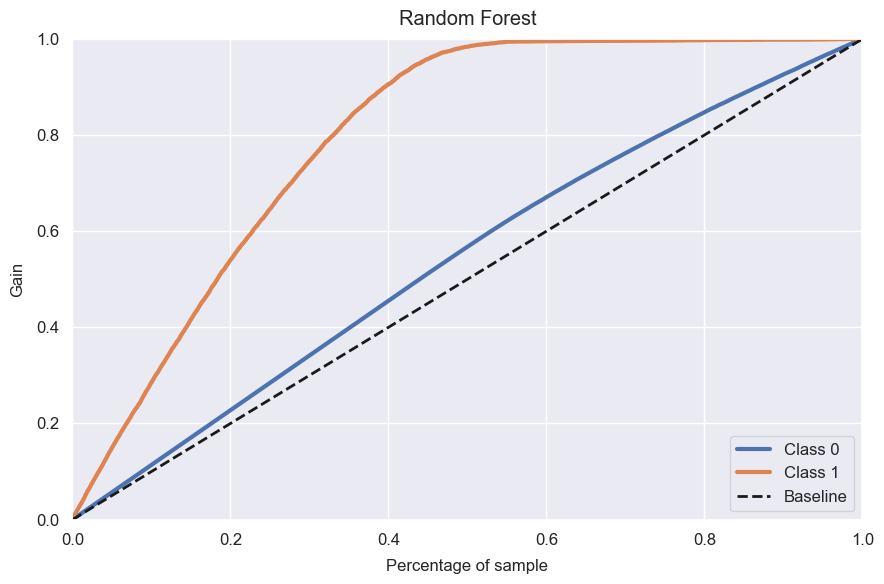

In [91]:
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
yhat_rf = rf_model.predict_proba(X_test)

skplt.metrics.plot_cumulative_gain(y_test, yhat_rf, title='Random Forest')

<Axes: title={'center': 'Random Forest - SMOTE'}, xlabel='Percentage of sample', ylabel='Gain'>

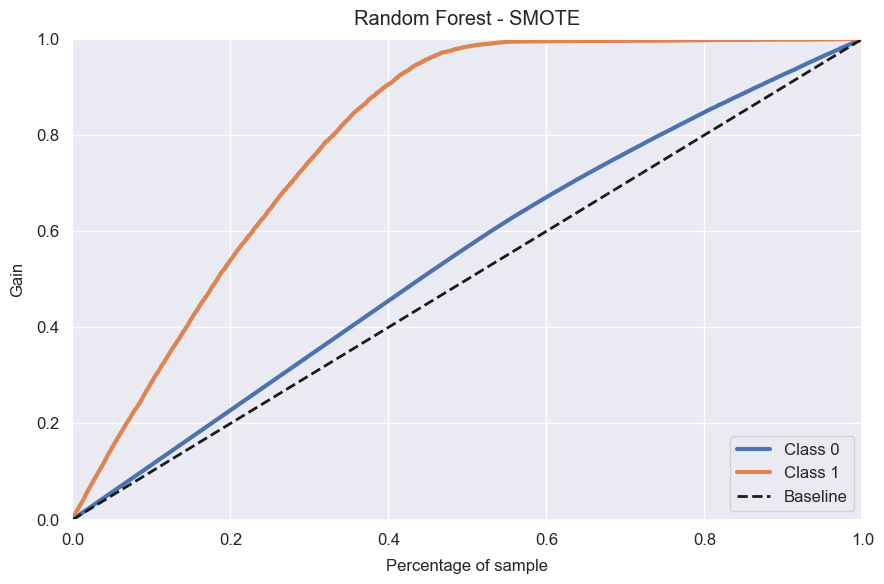

In [92]:
rf_model_bal = RandomForestClassifier()
rf_model_bal.fit(X_train_bal, y_train_bal)
yhat_rf_bal = rf_model.predict_proba(X_test)
skplt.metrics.plot_cumulative_gain(y_test, yhat_rf_bal, title='Random Forest - SMOTE')

<Axes: title={'center': 'Random Forest - PCA'}, xlabel='Percentage of sample', ylabel='Gain'>

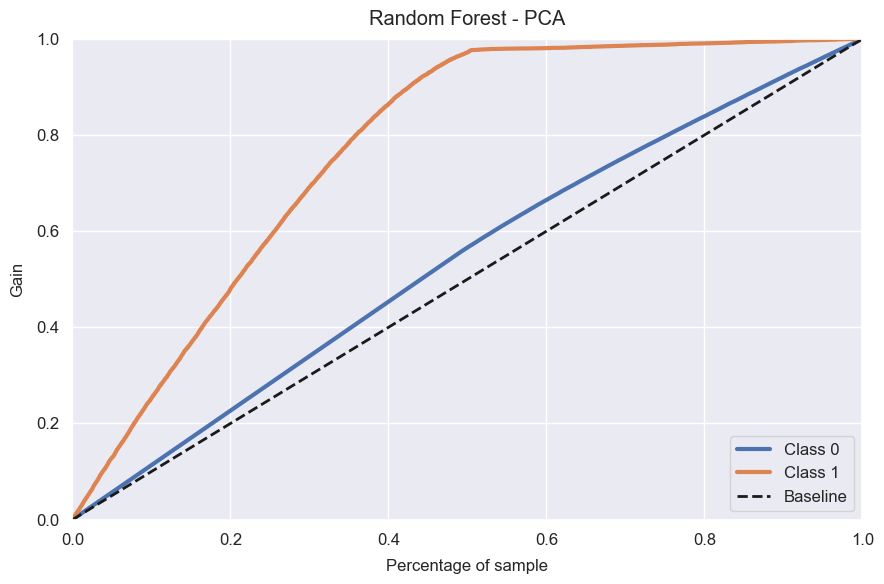

In [93]:
rf_model_pca = RandomForestClassifier()
rf_model_pca.fit(X_train_pca, y_train)
yhat_rf_pca = rf_model_pca.predict_proba(X_test_pca)
skplt.metrics.plot_cumulative_gain(y_test, yhat_rf_pca, title='Random Forest - PCA')

## 7.5 XGBoost

<Axes: title={'center': 'XGBoost'}, xlabel='Percentage of sample', ylabel='Gain'>

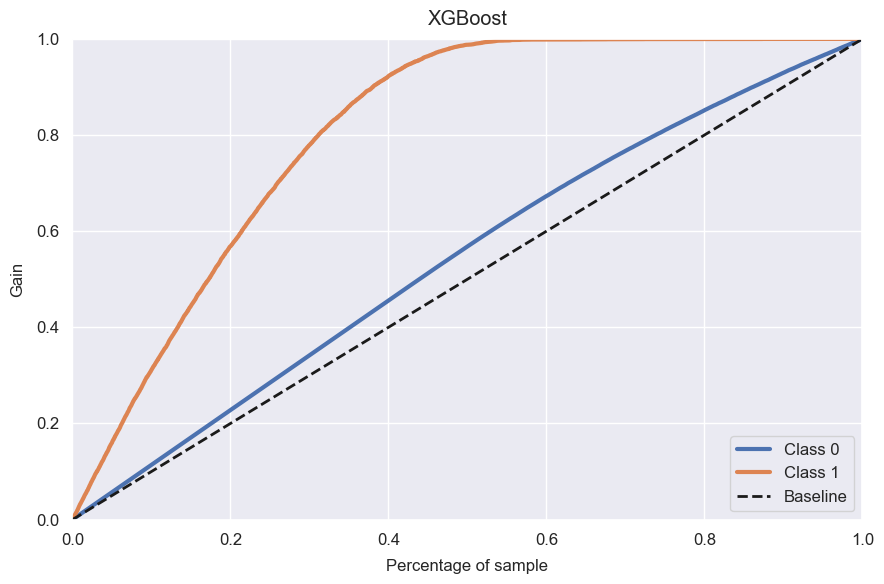

In [94]:
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)
yhat_xgb = xgb_model.predict_proba(X_test)
skplt.metrics.plot_cumulative_gain(y_test, yhat_xgb, title='XGBoost')

<Axes: title={'center': 'XGBoost - SMOTE'}, xlabel='Percentage of sample', ylabel='Gain'>

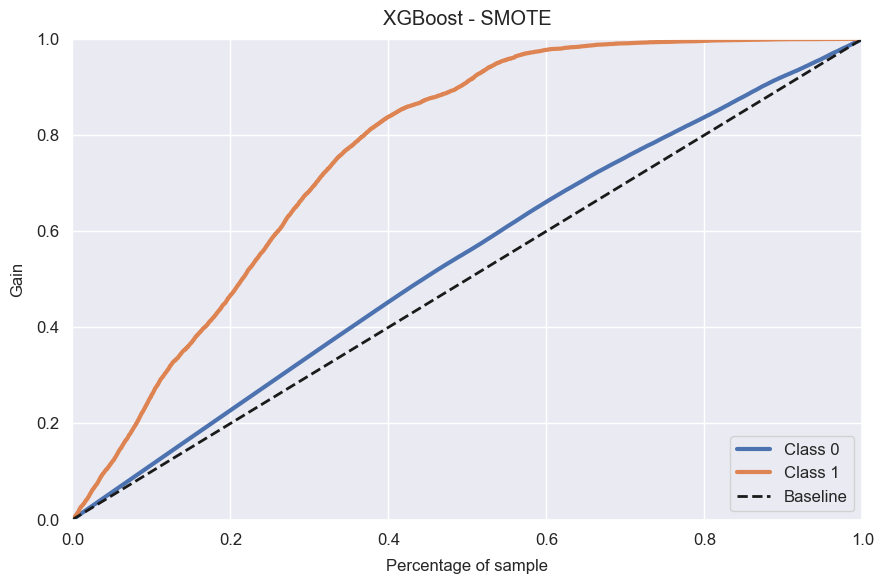

In [95]:
xgb_model_bal = XGBClassifier()
xgb_model_bal.fit(X_train_bal, y_train_bal)
yhat_xgb_bal = xgb_model_bal.predict_proba(X_test)
skplt.metrics.plot_cumulative_gain(y_test, yhat_xgb_bal, title= 'XGBoost - SMOTE')

<Axes: title={'center': 'XGBoost - PCA'}, xlabel='Percentage of sample', ylabel='Gain'>

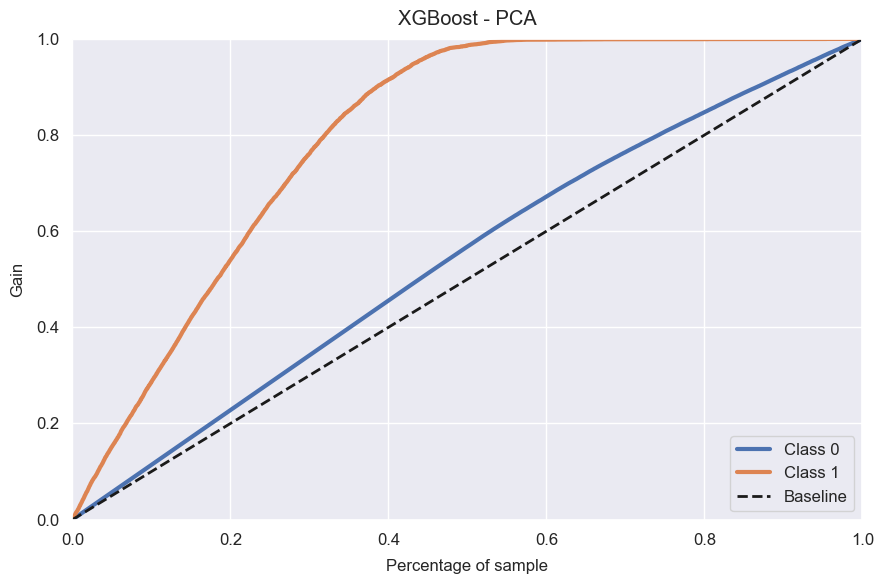

In [96]:
xgb_model_pca = XGBClassifier()
xgb_model_pca.fit(X_train_pca, y_train)
yhat_xgb_pca = xgb_model_pca.predict_proba(X_test_pca)
skplt.metrics.plot_cumulative_gain(y_test, yhat_xgb_pca, title='XGBoost - PCA')

# 8.0 Fine Tuning | Performance

In [97]:
#KNN
k = int(0.2*len(y_test))
knn_precision = precision_k(y_test, yhat_knn, k)
knn_recall = recall_k(y_test, yhat_knn, k)
knn_f1 = f1_k(knn_precision,knn_recall )
print(f'Precision@k: {knn_precision}. Recall@k: {knn_recall}. F1Score@k: {knn_f1}')

Precision@k: 0.302. Recall@k: 0.493. F1Score@k: 0.375


In [98]:
#Logistic Regression
k = int(0.2*len(y_test))
lr_precision = precision_k(y_test, yhat_lr, k)
lr_recall = recall_k(y_test, yhat_lr, k)
lr_f1 = f1_k(lr_precision,lr_recall )
print(f'Precision@k: {lr_precision}. Recall@k: {lr_recall}. F1Score@k: {lr_f1}')

Precision@k: 0.337. Recall@k: 0.55. F1Score@k: 0.418


In [99]:
#Extra trees
k = int(0.2*len(y_test))
et_precision = precision_k(y_test, yhat_et, k)
et_recall = recall_k(y_test, yhat_et, k)
et_f1 = f1_k(et_precision,et_recall )
print(f'Precision@k: {et_precision}. Recall@k: {et_recall}. F1Score@k: {et_f1}')

Precision@k: 0.323. Recall@k: 0.527. F1Score@k: 0.401


In [100]:
#XGBoost
k = int(0.2*len(y_test))
xgb_precision = precision_k(y_test, yhat_xgb, k)
xgb_recall = recall_k(y_test, yhat_xgb, k)
xgb_f1 = f1_k(xgb_precision,xgb_recall )
print(f'Precision@k: {xgb_precision}. Recall@k: {xgb_recall}. F1Score@k: {xgb_f1}')

Precision@k: 0.349. Recall@k: 0.569. F1Score@k: 0.433


## 8.1 Logistic Regression

In [101]:
k = int(0.2*len(y_test))
#k=0
#f1_scorer = f1_rank
#scorer = make_scorer(f1_rank, response_method='predict_proba')

In [ ]:
f = f1_rank(y_test, yhat_knn)
f

In [103]:
lr_model = LogisticRegression()

param_grid = {
    'solver': ['saga'],
    'penalty':['l1','l2','elasticnet'],
    'C': [0.1, 0.5, 1, 1.5],
    'l1_ratio': [0.25, 0.5, 0.75],
    'max_iter': [100, 300, 500]
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

k = int(0.2*len(y_test))
scorer = make_scorer(f1_rank, response_method="predict_proba")

search = RandomizedSearchCV(
    estimator=lr_model,
    param_distributions=param_grid,
    n_iter=5,
    scoring=scorer,
    cv=skf,
    verbose=1,
    random_state=42
    
)

In [105]:
%%time
search.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


C:\ProgramData\anaconda3\envs\pa004_311\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
C:\ProgramData\anaconda3\envs\pa004_311\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
C:\ProgramData\anaconda3\envs\pa004_311\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
C:\ProgramData\anaconda3\envs\pa004_311\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
C:\ProgramData\anaconda3\envs\pa004_311\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'.

CPU times: total: 4min 2s
Wall time: 17min 6s


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=LogisticRegression(), n_iter=5,
                   param_distributions={'C': [0.1, 0.5, 1, 1.5],
                                        'l1_ratio': [0.25, 0.5, 0.75],
                                        'max_iter': [100, 300, 500],
                                        'penalty': ['l1', 'l2', 'elasticnet'],
                                        'solver': ['saga']},
                   random_state=42,
                   scoring=make_scorer(f1_rank, response_method='predict_proba'),
                   verbose=1)

In [106]:
search.best_params_

{'solver': 'saga',
 'penalty': 'elasticnet',
 'max_iter': 300,
 'l1_ratio': 0.75,
 'C': 1}

In [107]:
search.best_score_

0.437

In [108]:
pd.set_option('display.max_colwidth', None)

In [109]:
lr_results = pd.DataFrame( search.cv_results_)
lr_results.T

,0,1,2,3,4
mean_fit_time,43.430551,32.149473,32.602427,42.780302,43.014618
std_fit_time,1.008924,0.861047,1.350566,0.894597,0.972227
mean_score_time,0.372381,0.373143,0.362838,0.361529,0.347711
std_score_time,0.015124,0.027172,0.014694,0.015345,0.007603
param_solver,saga,saga,saga,saga,saga
param_penalty,elasticnet,l2,l2,elasticnet,elasticnet
param_max_iter,300,100,300,100,500
param_l1_ratio,0.75,0.5,0.25,0.25,0.25
param_C,1,0.1,0.1,1.5,1
params,"{'solver': 'saga', 'penalty': 'elasticnet', 'max_iter': 300, 'l1_ratio': 0.75, 'C': 1}","{'solver': 'saga', 'penalty': 'l2', 'max_iter': 100, 'l1_ratio': 0.5, 'C': 0.1}","{'solver': 'saga', 'penalty': 'l2', 'max_iter': 300, 'l1_ratio': 0.25, 'C': 0.1}","{'solver': 'saga', 'penalty': 'elasticnet', 'max_iter': 100, 'l1_ratio': 0.25, 'C': 1.5}","{'solver': 'saga', 'penalty': 'elasticnet', 'max_iter': 500, 'l1_ratio': 0.25, 'C': 1}"


In [110]:
best_params = {'solver': 'saga', 'penalty': 'elasticnet', 'max_iter': 300, 'l1_ratio': 0.75, 'C': 1}

In [111]:
best_model_lr = LogisticRegression(**best_params)

best_model_lr.fit(X_train,y_train)

yhat_lr = best_model_lr.predict_proba(X_test)


Precision@k: 0.337. Recall@k: 0.549. F1Score@k: 0.418


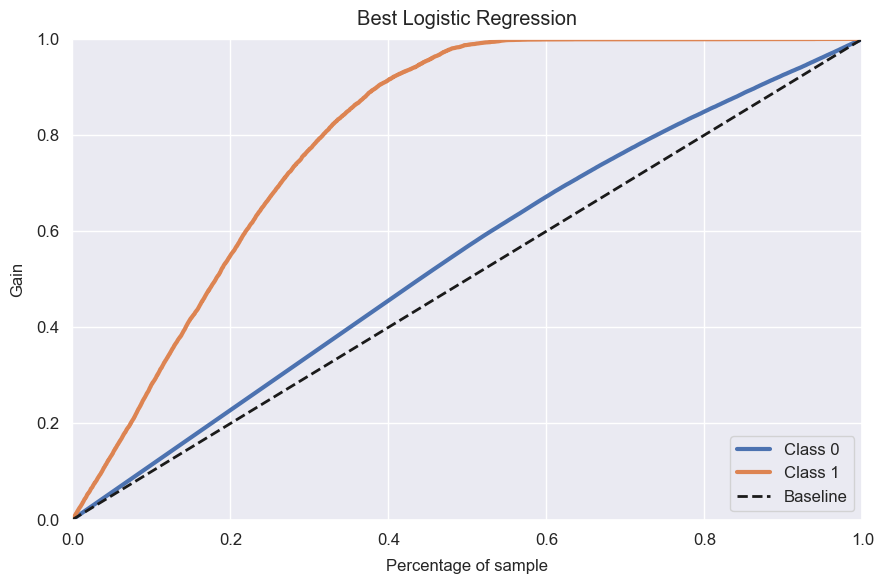

In [112]:
k = int(0.2*len(y_test))
p, r, f1 = metrics_k(y_test, yhat_lr)
gr = skplt.metrics.plot_cumulative_gain(y_test, yhat_lr, title='Best Logistic Regression')

## 8.2 XGBoost

In [113]:
xgb_model = XGBClassifier(random_state=42, scale_pos_weight=7)

param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.9, 1],
    'colsample_bytree': [0.7, 1.0],
    'gamma': [0, 0.1, 0.3],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [0, 1, 10]
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

k = int(0.2*len(y_test))
scorer = make_scorer(f1_rank, response_method="predict_proba")

search_xgb = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid,
    n_iter=5,
    scoring=scorer,
    cv=skf,
    verbose=1,
    random_state=42
    
)

In [114]:
%%time

search_xgb.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
CPU times: total: 4min 16s
Wall time: 33min 54s


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           feature_weights=None, gamma=None,
                                           grow...
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None, ...),
                   n_iter=5,
                   param_distributions={'colsample_bytree': [0.7, 1.0],
                                        'gamma': [0, 0.1, 0.3],
                                        'learning_rate': [0.01, 0.05, 0.1],
                                        'max_depth': [3, 5, 7],
                                        'n_estimators': [100, 300, 500],
                                        'reg_alpha': [0, 0.1, 1],
                                        'reg_lambda': [0, 1, 10],
                                        'subsample': [0.7, 0.9, 1]},
                   random_state=42,
                   scoring=make_scorer(f1_rank, response_method='predict_proba'),
                   verbose=1)

In [115]:
xgb_results = pd.DataFrame(search_xgb.cv_results_)
xgb_results.T

,0,1,2,3,4
mean_fit_time,33.876065,93.783922,21.161985,148.908277,73.796826
std_fit_time,1.183919,17.582004,0.549355,24.104489,17.322979
mean_score_time,2.867735,3.667234,2.116061,9.622208,1.902322
std_score_time,0.208717,0.706876,0.15168,3.04504,0.275206
param_subsample,1,0.9,1,0.9,0.7
param_reg_lambda,1,0,1,10,10
param_reg_alpha,1,1,0.1,0,0.1
param_n_estimators,300,300,100,500,300
param_max_depth,5,5,7,7,3
param_learning_rate,0.01,0.01,0.01,0.05,0.1


### 8.2.1 Melhor modelo

In [116]:
best_params = {'subsample': 0.7,
               'reg_lambda': 10,
               'reg_alpha': 0.1,
               'n_estimators': 300,
               'max_depth': 3,
               'learning_rate': 0.1,
               'gamma': 0.1,
               'colsample_bytree': 1.0}
best_score = 0.451

Precision@k: 0.351. Recall@k: 0.572. F1Score@k: 0.435


<Axes: title={'center': 'Best XGBoost'}, xlabel='Percentage of sample', ylabel='Gain'>

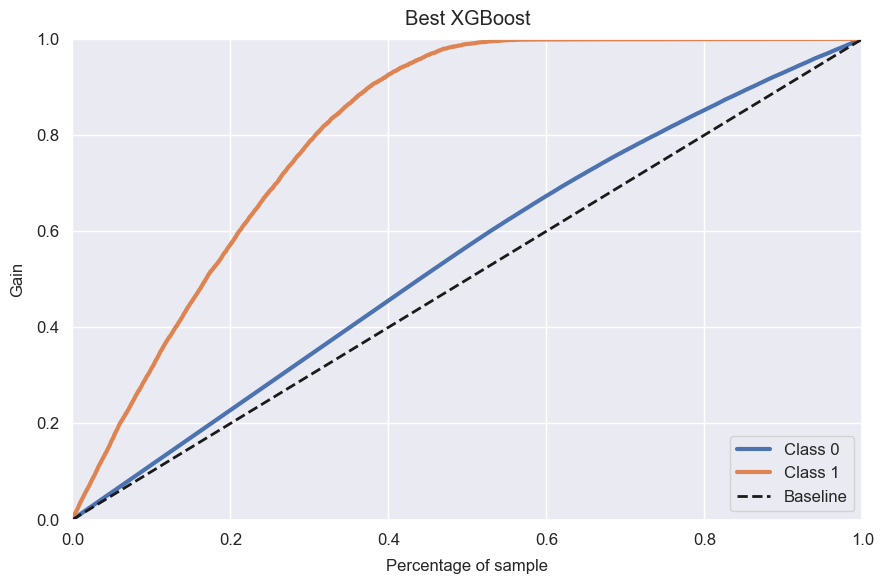

In [117]:
best_model_xgb = XGBClassifier(random_state=42, scale_pos_weight=7, **best_params)

best_model_xgb.fit(X_train, y_train)

yhat_xgb = best_model_xgb.predict_proba(X_test)

k = int(0.2*len(y_test))
metrics_k(y_test, yhat_xgb)
skplt.metrics.plot_cumulative_gain(y_test, yhat_xgb, title='Best XGBoost')

<Axes: title={'center': 'XGBost Lift Curve'}, xlabel='Percentage of sample', ylabel='Lift'>

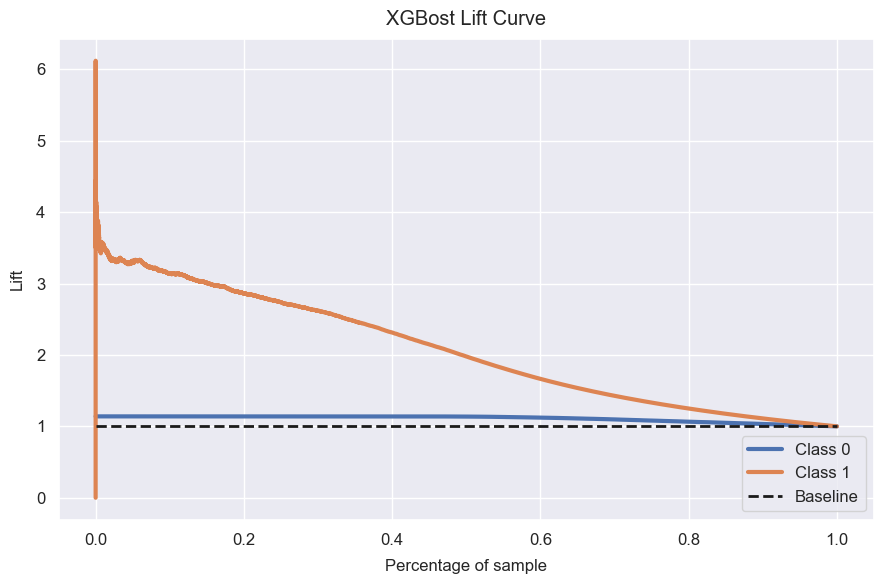

In [118]:
# Lift curve
skplt.metrics.plot_lift_curve(y_test, yhat_xgb, title= 'XGBost Lift Curve')

In [119]:
#exportando modelo
pickle.dump(best_model_xgb, open('src/models/xgboost_model.pkl', 'wb'))

# 9.0 Tradução da métrica para negócios

* Qual seria a economia gerada?
    - O tamanho da lista que não precisa ser varrida vezes o custo para contatar um potencial cliente.
* Qual seria o potencial faturamento gerado?
    - Seria a quantidade de potenciais clientes no início da lista vezes o valor médio de seguro
* Estimativa levando em conta que, visualmente, mais de 90% dos leads estão concentrados nos 40% primeiros itens da lista.

## 9.1 Redução de custos
* R$ 457.332,00

In [120]:
e = (0.6*len(y_test)) * 10
print(f'A redução de custos será de: R$ {e}.')

A redução de custos será de: R$ 457332.0.


## 9.2 Aumento de faturamento
* R$ 70.503.500,00

In [121]:
k = int(0.4*len(y_test))
r = recall_k(y_test, yhat_xgb, k)
r

0.925

In [122]:
f = r * k * 2500
print(f'O potencial faturamento será de: R$ {f:.2f}.')

O potencial faturamento será de: R$ 70503500.00.


# 10.0 Deploy | Prototipação da API

## 10.1 Classe de funções

In [61]:
class HealthInsurance():
    def __init__(self):
        self.home_path = 'D:/Profissional/TI/Repos/Comunidade_DS/PA004-Propensao-de-compra/Projeto/'
        self.age_scaler = pickle.load(open(self.home_path + 'src/features/age_scaler.pkl', 'rb'))
        self.vintage_scaler = pickle.load(open(self.home_path + 'src/features/vintage_scaler.pkl', 'rb'))
        self.annual_premium_scaler = pickle.load(open(self.home_path + 'src/features/annual_premium_scaler.pkl', 'rb'))
        self.gender_scaler = pickle.load(open(self.home_path + 'src/features/gender_scaler.pkl', 'rb'))
        self.vehicle_damage_scaler = pickle.load( open(self.home_path + 'src/features/vehicle_damage_scaler.pkl', 'rb'))
        self.vehicle_age_scaler = pickle.load(open(self.home_path + 'src/features/vehicle_age_scaler.pkl', 'rb'))
        self.region_code_scaler = pickle.load(open(self.home_path + 'src/features/region_code_scaler.pkl', 'rb'))
        self.policy_sales_channel_scaler = pickle.load(open(self.home_path + 'src/features/policy_sales_channel_scaler.pkl', 'rb'))
   
    def data_preparation(self, df):
        df1 = df.copy()
        #renomeando colunas
        cols_old = list(df1.columns)
        cols_new =  list(map(lambda x: inflection.underscore(x), cols_old))
        df1.columns = cols_new
        # aplicando pre-processamento
        df1['age'] = self.age_scaler.transform(df1[['age']].values)
        df1['vintage'] = self.vintage_scaler.transform(df1[['vintage']].values)
        df1['annual_premium'] = self.annual_premium_scaler.transform(df1[['annual_premium']].values)
        df1['gender'] = self.gender_scaler.transform(df1[['gender']].values)
        df1['vehicle_damage'] = self.vehicle_damage_scaler.transform(df1[['vehicle_damage']].values)
        df1['vehicle_age'] = self.vehicle_age_scaler.transform(df1[['vehicle_age']].values)
        df1['region_code'] = self.region_code_scaler.transform(df1[['region_code']].values)
        df1['policy_sales_channel'] = self.policy_sales_channel_scaler.transform(df1[['policy_sales_channel']].values)

        cols_selected = ['policy_sales_channel', 'previously_insured', 'region_code', 'vehicle_damage',
                         'age', 'annual_premium', 'vintage']
        return df1[cols_selected]

    def get_prediction(self, model, original_data, test_data):
        pred = model.predict_proba(test_data)
        original_data['prediction'] = pred[:,1]
        return original_data.to_json(orient='records', date_format='iso')

## 10.2 API Handler

In [1]:
from flask import Flask, request, Response

In [ ]:
import pickle
import pandas
from flask import Flask, request, Response
from healthinsurance.Healthinsurance import HealthInsurance

# carregando modelo
path = 'D:/Profissional/TI/Repos/Comunidade_DS/PA004-Propensao-de-compra/Projeto'
model = pickle.load(open(path + 'src/models/xgboost_model.pkl', 'rb'))

# inicializando API
app = Flask(__name__)

@app.route('/predict', methods=['POST'])
def health_insurance_predict():
    test_json = request.get_json()

    #testando dados recebidos
    if test_json: # há dados
        if isinstance(test_json, dict): # única linha
            test_raw = pd.DataFrame(test_json, index=[0])
        else: #múltiplas linhas
            test_raw = pd.DataFrame(test_json, columns=test_json[0].keys())

        # instanciando classe HealthInsurance
        pipeline = HealthInsurance()

        #preparando dados
        df1 = pipeline.data_preparation(test_raw)

        #previsão
        df_response = pipeline.get_prediction(model, test_raw, df1)

        return df_response

    else:
        return Response('{}', status=200, mimetype= 'application/json')

if __name__ == '__main__':
    app.run('0.0.0.0', debug=True)
            



## 10.3 API tester

In [2]:
import requests
import json

In [27]:
df_t = df_test_raw.sample(30)

In [4]:
#df_t.to_csv('../csv/teste.csv', index=False)
df_t = pd.read_csv('../csv/teste.csv')

In [5]:
cols_old = list(df_t.columns)
cols_new =  list(map(lambda x: inflection.underscore(x), cols_old))
df_t.columns = cols_new

In [6]:
data = json.dumps(df_t.to_dict(orient= 'records'))

In [7]:
data

'[{"id": 71608, "gender": "Male", "age": 36, "driving_license": 1, "region_code": 28.0, "previously_insured": 0, "vehicle_age": "1-2 Year", "vehicle_damage": "Yes", "annual_premium": 33491.0, "policy_sales_channel": 26.0, "vintage": 287}, {"id": 292587, "gender": "Female", "age": 27, "driving_license": 1, "region_code": 28.0, "previously_insured": 0, "vehicle_age": "< 1 Year", "vehicle_damage": "Yes", "annual_premium": 27166.0, "policy_sales_channel": 26.0, "vintage": 220}, {"id": 30301, "gender": "Male", "age": 26, "driving_license": 1, "region_code": 18.0, "previously_insured": 0, "vehicle_age": "< 1 Year", "vehicle_damage": "Yes", "annual_premium": 34050.0, "policy_sales_channel": 152.0, "vintage": 56}, {"id": 29657, "gender": "Male", "age": 23, "driving_license": 1, "region_code": 50.0, "previously_insured": 0, "vehicle_age": "< 1 Year", "vehicle_damage": "Yes", "annual_premium": 32980.0, "policy_sales_channel": 151.0, "vintage": 71}, {"id": 170143, "gender": "Male", "age": 22, "dr

In [10]:
# API call
url = 'https://healthinsurance-api-render.onrender.com/predict'
#url =  'http://127.0.0.1:5000/predict'
header = {'Content-type': 'application/json'}

r = requests.post(url, data=data, headers=header)
print(f'Status code: {r.status_code}')

Status code: 200


In [11]:
df_list = pd.DataFrame(r.json())
df_list.sort_values('prediction', ascending=False)

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,prediction
14,365248,Female,31,1,28.0,0,1-2 Year,Yes,38358.0,158.0,222,0.857607
0,71608,Male,36,1,28.0,0,1-2 Year,Yes,33491.0,26.0,287,0.827728
18,262716,Female,45,1,28.0,0,1-2 Year,Yes,47715.0,26.0,123,0.813908
17,265836,Male,45,1,28.0,0,1-2 Year,Yes,33607.0,26.0,155,0.797716
13,31430,Male,36,1,46.0,0,1-2 Year,Yes,19515.0,124.0,261,0.795001
1,292587,Female,27,1,28.0,0,< 1 Year,Yes,27166.0,26.0,220,0.780015
28,169073,Male,54,1,47.0,0,1-2 Year,Yes,30236.0,154.0,123,0.701755
6,142560,Male,55,1,28.0,0,> 2 Years,Yes,56325.0,42.0,26,0.663368
2,30301,Male,26,1,18.0,0,< 1 Year,Yes,34050.0,152.0,56,0.632037
8,257720,Male,23,1,4.0,0,1-2 Year,Yes,2630.0,156.0,103,0.606440


In [41]:
df_list = pd.DataFrame(r.json())
df_list.sort_values('prediction', ascending=False)

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,prediction
14,365248,Female,31,1,28.0,0,1-2 Year,Yes,38358.0,158.0,222,0.857607
0,71608,Male,36,1,28.0,0,1-2 Year,Yes,33491.0,26.0,287,0.827728
18,262716,Female,45,1,28.0,0,1-2 Year,Yes,47715.0,26.0,123,0.813908
17,265836,Male,45,1,28.0,0,1-2 Year,Yes,33607.0,26.0,155,0.797716
13,31430,Male,36,1,46.0,0,1-2 Year,Yes,19515.0,124.0,261,0.795001
1,292587,Female,27,1,28.0,0,< 1 Year,Yes,27166.0,26.0,220,0.780015
28,169073,Male,54,1,47.0,0,1-2 Year,Yes,30236.0,154.0,123,0.701755
6,142560,Male,55,1,28.0,0,> 2 Years,Yes,56325.0,42.0,26,0.663368
2,30301,Male,26,1,18.0,0,< 1 Year,Yes,34050.0,152.0,56,0.632037
8,257720,Male,23,1,4.0,0,1-2 Year,Yes,2630.0,156.0,103,0.606440
